In [2]:
import os,sys
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import pandas as pd
from osgeo import ogr,gdal
import xarray as xr
import rasterio
import numpy as np
import pyproj
from pygeos import from_wkb,from_wkt
import pygeos
from tqdm import tqdm
from shapely.wkb import loads
from pathlib import Path
import glob
from shapely.geometry import mapping
pd.options.mode.chained_assignment = None
from rasterio.mask import mask
import rioxarray
import matplotlib.pyplot as plt
from scipy import integrate
from collections.abc import Iterable

import warnings
warnings.filterwarnings("ignore")

from scipy import integrate

In [3]:
gdal.SetConfigOption("OSM_CONFIG_FILE", os.path.join('..',"osmconf.ini"))

# change paths to make it work on your own machine
data_path = os.path.join('C:\\','Data','pg_risk_analysis')
tc_path = os.path.join(data_path,'tc_netcdf')
fl_path = os.path.join(data_path,'GLOFRIS')
osm_data_path = os.path.join('C:\\','Data','country_osm')
pg_data_path = os.path.join(data_path,'pg_data')
vul_curve_path = os.path.join(data_path,'vulnerability_curves','input_vulnerability_data.xlsx')
output_path = os.path.join('C:\\','projects','pg_risk_analysis','output')
ne_path = os.path.join(data_path,'..',"natural_earth","ne_10m_admin_0_countries.shp")

In [6]:
df = pd.read_excel(vul_curve_path,sheet_name='wind_curves',skiprows=10)
df

,Wind speed (m/s),Failure probability,Failure probability.1,Failure probability.2,Failure probability.3,Failure probability.4,Failure probability.5,Failure probability.6,Failure probability.7,Failure probability.8,...,Failure probability.99,Failure probability.100,Failure probability.101,Failure probability.102,Failure probability.103,Failure probability.104,Failure probability.105,Failure probability.106,Failure probability.107,Failure probability.108
0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.388889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.235200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,290.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
291,290.113636,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
292,295.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
293,296.420455,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


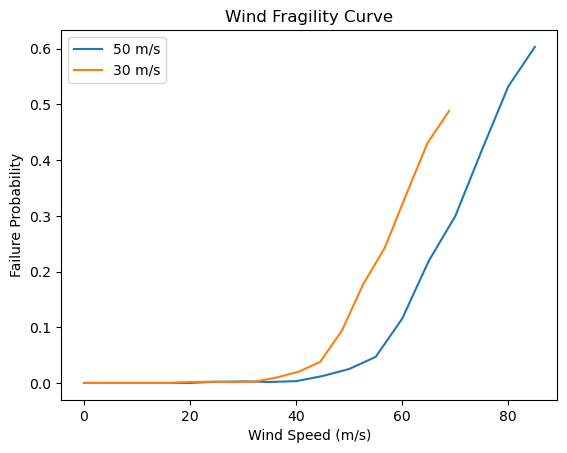

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Original wind fragility curve data
wind_speeds_50 = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85])
failure_probs_50 = np.array([0, 0, 0, 0, 0, 0.0021, 0.0027, 0.0017, 0.0032, 0.0124, 0.025, 0.0468, 0.1155, 0.219, 0.2995, 0.4177, 0.5325, 0.6033])

# Scaled wind fragility curve data
scaling_factor = 0.81
wind_speeds_30 = wind_speeds_50 * scaling_factor
failure_probs_30 = failure_probs_50 * scaling_factor

# Plot both curves on the same graph
plt.plot(wind_speeds_50, failure_probs_50, label='50 m/s')
plt.plot(wind_speeds_30, failure_probs_30, label='30 m/s')

# Add labels and legend
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Failure Probability')
plt.title('Wind Fragility Curve')
plt.legend()

# Show the plot
plt.show()


In [15]:
def flatten(xs):
    for x in xs:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            yield from flatten(x)
        else:
            yield x

def query_b(geoType,keyCol,**valConstraint):
    """
    This function builds an SQL query from the values passed to the retrieve() function.
    Arguments:
         *geoType* : Type of geometry (osm layer) to search for.
         *keyCol* : A list of keys/columns that should be selected from the layer.
         ***valConstraint* : A dictionary of constraints for the values. e.g. WHERE 'value'>20 or 'value'='constraint'
    Returns:
        *string: : a SQL query string.
    """
    query = "SELECT " + "osm_id"
    for a in keyCol: query+= ","+ a  
    query += " FROM " + geoType + " WHERE "
    # If there are values in the dictionary, add constraint clauses
    if valConstraint: 
        for a in [*valConstraint]:
            # For each value of the key, add the constraint
            for b in valConstraint[a]: query += a + b
        query+= " AND "
    # Always ensures the first key/col provided is not Null.
    query+= ""+str(keyCol[0]) +" IS NOT NULL" 
    return query 


def retrieve(osm_path,geoType,keyCol,**valConstraint):
    """
    Function to extract specified geometry and keys/values from OpenStreetMap
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.     
        *geoType* : Type of Geometry to retrieve. e.g. lines, multipolygons, etc.
        *keyCol* : These keys will be returned as columns in the dataframe.
        ***valConstraint: A dictionary specifiying the value constraints.  
        A key can have multiple values (as a list) for more than one constraint for key/value.  
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all columns, geometries, and constraints specified.    
    """
    driver=ogr.GetDriverByName('OSM')
    data = driver.Open(osm_path)
    query = query_b(geoType,keyCol,**valConstraint)
    sql_lyr = data.ExecuteSQL(query)
    features =[]
    # cl = columns 
    cl = ['osm_id'] 
    for a in keyCol: cl.append(a)
    if data is not None:
        print('query is finished, lets start the loop')
        for feature in tqdm(sql_lyr,desc='extract'):
            #try:
            if feature.GetField(keyCol[0]) is not None:
                geom1 = (feature.geometry().ExportToWkt())
                #print(geom1)
                geom = from_wkt(feature.geometry().ExportToWkt()) 
                if geom is None:
                    continue
                # field will become a row in the dataframe.
                field = []
                for i in cl: field.append(feature.GetField(i))
                field.append(geom)   
                features.append(field)
            #except:
            #    print("WARNING: skipped OSM feature")   
    else:
        print("ERROR: Nonetype error when requesting SQL. Check required.")    
    cl.append('geometry')                   
    if len(features) > 0:
        return pd.DataFrame(features,columns=cl)
    else:
        print("WARNING: No features or No Memory. returning empty GeoDataFrame") 
        return pd.DataFrame(columns=['osm_id','geometry'])

def power_polyline(osm_path):
    """
    Function to extract all energy linestrings from OpenStreetMap  
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.        
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with specified unique energy linestrings.
    """
    df = retrieve(osm_path,'lines',['power','voltage'])
    
    df = df.reset_index(drop=True).rename(columns={'power': 'asset'})
    
    #print(df) #check infra keys
    
    return df.reset_index(drop=True)

# def power_polygon(osm_path): # check with joel, something was wrong here with extracting substations
#     """
#     Function to extract energy polygons from OpenStreetMap  
#     Arguments:
#         *osm_path* : file path to the .osm.pbf file of the region 
#         for which we want to do the analysis.        
#     Returns:
#         *GeoDataFrame* : a geopandas GeoDataFrame with specified unique energy linestrings.
#     """
#     df = retrieve(osm_path,'multipolygons',['other_tags']) 
    
#     df = df.loc[(df.other_tags.str.contains('power'))]   #keep rows containing power data         
#     df = df.reset_index(drop=True).rename(columns={'other_tags': 'asset'})     
    
#     df['asset'].loc[df['asset'].str.contains('"power"=>"substation"', case=False)]  = 'substation' #specify row
#     df['asset'].loc[df['asset'].str.contains('"power"=>"plant"', case=False)] = 'plant' #specify row
    
#     df = df.loc[(df.asset == 'substation') | (df.asset == 'plant')]
            
#     return df.reset_index(drop=True) 

def electricity(osm_path):
    """
    Function to extract building polygons from OpenStreetMap    
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.        
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique building polygons.    
    """
    df = retrieve(osm_path,'multipolygons',['power'])
    
    df = df.reset_index(drop=True).rename(columns={'power': 'asset'})
    
    #df = df[df.asset!='generator']
    df['asset'].loc[df['asset'].str.contains('"power"=>"substation"', case=False)]  = 'substation' #specify row
    df['asset'].loc[df['asset'].str.contains('"power"=>"plant"', case=False)] = 'plant' #specify row
        
    df = df.loc[(df.asset == 'substation') | (df.asset == 'plant')]
    
    print(df['asset'].unique())
    
    return df.reset_index(drop=True)

# def retrieve_poly_subs(osm_path, w_list, b_list):
#     """
#     Function to extract electricity substation polygons from OpenStreetMap
#     Arguments:
#         *osm_path* : file path to the .osm.pbf file of the region
#         for which we want to do the analysis.
#         *w_list* :  white list of keywords to search in the other_tags columns
#         *b_list* :  black list of keywords of rows that should not be selected
#     Returns:
#         *GeoDataFrame* : a geopandas GeoDataFrame with specified unique substation.
#     """
#     df = retrieve(osm_path,'multipolygons',['other_tags'])
#     df = df[df.other_tags.str.contains('substation', case=False, na=False)]
#     #df = df.loc[(df.other_tags.str.contains('substation'))]
#     df = df[~df.other_tags.str.contains('|'.join(b_list))]
#     #df = df.reset_index(drop=True).rename(columns={'other_tags': 'asset'})
#     df['asset']  = 'substation' #specify row
#     #df = df.loc[(df.asset == 'substation')] #specify row
#     return df.reset_index(drop=True)

def power_point(osm_path):
    """
    Function to extract energy points from OpenStreetMap  
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.        
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with specified unique energy linestrings.
    """   
    df = retrieve(osm_path,'points',['other_tags']) 
    df = df.loc[(df.other_tags.str.contains('power'))]  #keep rows containing power data       
    df = df.reset_index(drop=True).rename(columns={'other_tags': 'asset'})     
        
    df['asset'].loc[df['asset'].str.contains('"power"=>"tower"', case=False)]  = 'power_tower' #specify row
    df['asset'].loc[df['asset'].str.contains('"power"=>"pole"', case=False)] = 'power_pole' #specify row
    #df['asset'].loc[df['asset'].str.contains('"utility"=>"power"', case=False)] = 'power_tower' #specify row
    
    df = df.loc[(df.asset == 'power_tower') | (df.asset == 'power_pole')]
            
    return df.reset_index(drop=True)

In [16]:
#new
osm_power_infra = extract_osm_infrastructure('LAO',osm_data_path)

query is finished, lets start the loop


extract: 100%|██████████████████████████████████████████████████████████████████████| 439/439 [00:02<00:00, 163.62it/s]


query is finished, lets start the loop


extract: 100%|█████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  4.01it/s]


['plant' 'substation']
query is finished, lets start the loop


extract: 100%|█████████████████████████████████████████████████████████████████| 45489/45489 [00:05<00:00, 9014.30it/s]


In [8]:
#old
osm_power_infra = extract_osm_infrastructure('LAO',osm_data_path)

query is finished, lets start the loop


extract: 100%|██████████████████████████████████████████████████████████████████████| 439/439 [00:02<00:00, 154.66it/s]


query is finished, lets start the loop


extract: 100%|█████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  4.00it/s]


   osm_id       asset                                           geometry
0    None       plant  MULTIPOLYGON (((102.119 20.808, 102.119 20.808...
1    None       plant  MULTIPOLYGON (((101.816 19.244, 101.817 19.244...
2    None   generator  MULTIPOLYGON (((102.736 18.332, 102.736 18.332...
3    None       plant  MULTIPOLYGON (((102.776 18.751, 102.776 18.751...
4    None       plant  MULTIPOLYGON (((101.283 19.69, 101.282 19.689,...
5    None  substation  MULTIPOLYGON (((105.997 16.96, 105.998 16.96, ...
6    None       plant  MULTIPOLYGON (((102.547 18.531, 102.547 18.531...
7    None       plant  MULTIPOLYGON (((104.637 18.294, 104.637 18.294...
8    None       plant  MULTIPOLYGON (((104.539 18.21, 104.539 18.209,...
9    None       plant  MULTIPOLYGON (((102.346 21.41, 102.345 21.411,...
10   None       plant  MULTIPOLYGON (((102.118 18.792, 102.118 18.791...
11   None       plant  MULTIPOLYGON (((101.407 21.033, 101.408 21.033...
12   None   generator  MULTIPOLYGON (((107.406 15.3

extract: 100%|█████████████████████████████████████████████████████████████████| 45489/45489 [00:04<00:00, 9472.30it/s]


In [20]:
def reproject(df_ds, current_crs="epsg:4326", approximate_crs="epsg:3857"):

    # Extract the input geometries as a numpy array of coordinates
    geometries = df_ds['geometry']
    coords = pygeos.get_coordinates(geometries)

    # Transform the coordinates using pyproj
    transformer = pyproj.Transformer.from_crs(current_crs, approximate_crs, always_xy=True)
    new_coords = transformer.transform(coords[:, 0], coords[:, 1])

    # Create a new GeoSeries with the reprojected coordinates
    return pygeos.set_coordinates(geometries.copy(), np.array(new_coords).T)

def buffer_assets(assets, buffer_size=100):
    """
    Create a buffer of a specified size around the geometries in a GeoDataFrame.
    
    Args:
        assets (GeoDataFrame): A GeoDataFrame containing geometries to be buffered.
        buffer_size (int, optional): The distance in the units of the GeoDataFrame's CRS to buffer the geometries.
            Defaults to 100.
    
    Returns:
        GeoDataFrame: A new GeoDataFrame with an additional column named 'buffered' containing the buffered
            geometries.
    """
    # Create a buffer of the specified size around the geometries
    assets['buffered'] = pygeos.buffer(assets.geometry.values, buffer_size)
    
    return assets

def load_curves_maxdam(vul_curve_path,hazard_type):
    """[summary]

    Args:
        data_path ([type]): [description]

    Returns:
        [type]: [description]
    """

    if hazard_type == 'tc':
        sheet_name = 'wind_curves'
    
    elif hazard_type == 'fl':
        sheet_name = 'flooding_curves'
    
    # load curves and maximum damages as separate inputs
    curves = pd.read_excel(vul_curve_path,sheet_name=sheet_name,skiprows=10,index_col=[0])
    
    maxdam = pd.read_excel(vul_curve_path,sheet_name=sheet_name,index_col=[0],header=[0,1]).iloc[:7]
    maxdam = maxdam.rename({'substation_point':'substation'},level=0,axis=1)

    curves.columns = maxdam.columns
        
    #transpose maxdam so its easier work with the dataframe
    maxdam = maxdam.T

    #interpolate the curves to fill missing values
    curves = curves.interpolate()
       
    return curves,maxdam


def overlay_hazard_assets(df_ds, assets):
    """
    Overlay a set of assets with a hazard dataset and return the subset of assets that intersect with
    one or more hazard polygons or lines.
    
    Args:
        df_ds (GeoDataFrame): A GeoDataFrame containing the hazard dataset.
        assets (GeoDataFrame): A GeoDataFrame containing the assets to be overlaid with the hazard dataset.
    
    Returns:
        ndarray: A numpy array of integers representing the indices of the hazard geometries that intersect with
            the assets. If the assets have a 'buffered' column, the buffered geometries are used for the overlay.
    """
    hazard_tree = pygeos.STRtree(df_ds.geometry.values)
    if (pygeos.get_type_id(assets.iloc[0].geometry) == 3) | (pygeos.get_type_id(assets.iloc[0].geometry) == 6):
        return  hazard_tree.query_bulk(assets.geometry,predicate='intersects')    
    else:
        return  hazard_tree.query_bulk(assets.buffered,predicate='intersects')
    
    
def get_damage_per_asset_per_rp(asset,df_ds,assets,curves,maxdam,return_period,country):
    """
    Calculates the damage per asset per return period based on asset type, hazard curves and maximum damage

    Args:
        asset (tuple): Tuple with two dictionaries, containing the asset index and the hazard point index of the asset
        df_ds (pandas.DataFrame): A pandas DataFrame containing hazard points with a 'geometry' column
        assets (geopandas.GeoDataFrame): A GeoDataFrame containing asset geometries and asset type information
        curves (dict): A dictionary with the asset types as keys and their corresponding hazard curves as values
        maxdam (pandas.DataFrame): A pandas DataFrame containing the maximum damage for each asset type
        return_period (str): The return period for which the damage should be calculated
        country (str): The country for which the damage should be calculated

    Returns:
        list or tuple: Depending on the input, the function either returns a list of tuples with the asset index, the curve name and the calculated damage, or a tuple with None, None, None if no hazard points are found
    """
    
    # find the exact hazard overlays:
    get_hazard_points = df_ds.iloc[asset[1]['hazard_point'].values].reset_index()
    get_hazard_points = get_hazard_points.loc[pygeos.intersects(get_hazard_points.geometry.values,assets.iloc[asset[0]].geometry)]

    asset_type = assets.iloc[asset[0]].asset
    asset_geom = assets.iloc[asset[0]].geometry

    if asset_type in ['plant','substation','generator']:
        #if plant,substation are points, do not calculate the area
        if pygeos.area(asset_geom) == 0:
            maxdam_asset = maxdam.loc[asset_type].MaxDam
            lowerdam_asset = maxdam.loc[asset_type].LowerDam
            upperdam_asset = maxdam.loc[asset_type].UpperDam
        else:
            maxdam_asset = maxdam.loc[asset_type].MaxDam/pygeos.area(asset_geom)
            lowerdam_asset = maxdam.loc[asset_type].LowerDam/pygeos.area(asset_geom)
            upperdam_asset = maxdam.loc[asset_type].UpperDam/pygeos.area(asset_geom)
    else:
        maxdam_asset = maxdam.loc[asset_type].MaxDam
        lowerdam_asset = maxdam.loc[asset_type].LowerDam
        upperdam_asset = maxdam.loc[asset_type].UpperDam

    hazard_intensity = curves[asset_type].index.values
    
    if isinstance(curves[asset_type],pd.core.series.Series):
        fragility_values = curves[asset_type].values.flatten()
        only_one = True
        curve_name = curves[asset_type].name
    elif len(curves[asset_type].columns) == 1:
        fragility_values = curves[asset_type].values.flatten()      
        only_one = True   
        curve_name = curves[asset_type].columns[0]
    else:
        fragility_values = curves[asset_type].values#.T[0]
        maxdam_asset = maxdam_asset.values#[0]
        only_one = False

    if len(get_hazard_points) == 0:
        if only_one:
            return [return_period,asset[0],curve_name,0,0,0]
        else:
            return [return_period,asset[0],curves[asset_type].columns[0],0,0,0]
            
    else:
        if only_one:    
            # run the calculation as normal when the asset just has a single curve
            if pygeos.get_type_id(asset_geom) == 1:            
                get_hazard_points['overlay_meters'] = pygeos.length(pygeos.intersection(get_hazard_points.geometry.values,asset_geom))
                return [return_period,asset[0],curve_name,np.sum((np.interp(get_hazard_points[return_period].values,hazard_intensity,
                                                             fragility_values))*get_hazard_points.overlay_meters*maxdam_asset),
                                                          np.sum((np.interp(get_hazard_points[return_period].values,hazard_intensity,
                                                             fragility_values))*get_hazard_points.overlay_meters*lowerdam_asset),
                                                          np.sum((np.interp(get_hazard_points[return_period].values,hazard_intensity,
                                                             fragility_values))*get_hazard_points.overlay_meters*upperdam_asset)]

            elif (pygeos.get_type_id(asset_geom) == 3) | (pygeos.get_type_id(asset_geom) == 6) :
                get_hazard_points['overlay_m2'] = pygeos.area(pygeos.intersection(get_hazard_points.geometry.values,asset_geom))
                return [return_period,asset[0],curve_name,get_hazard_points.apply(lambda x: np.interp(x[return_period],hazard_intensity, 
                                                                  fragility_values)*maxdam_asset*x.overlay_m2,axis=1).sum(),
                                                          get_hazard_points.apply(lambda x: np.interp(x[return_period],hazard_intensity, 
                                                                  fragility_values)*lowerdam_asset*x.overlay_m2,axis=1).sum(),
                                                          get_hazard_points.apply(lambda x: np.interp(x[return_period],hazard_intensity, 
                                                                  fragility_values)*upperdam_asset*x.overlay_m2,axis=1).sum()]  

            else:
                return [return_period,asset[0],curve_name,np.sum((np.interp(get_hazard_points[return_period].values,
                                                             hazard_intensity,fragility_values))*maxdam_asset),
                                                          np.sum((np.interp(get_hazard_points[return_period].values,
                                                             hazard_intensity,fragility_values))*lowerdam_asset),
                                                          np.sum((np.interp(get_hazard_points[return_period].values,
                                                             hazard_intensity,fragility_values))*upperdam_asset)]
        else:
            # run the calculation when the asset has multiple curves
            if pygeos.get_type_id(asset_geom) == 1:            
                get_hazard_points['overlay_meters'] = pygeos.length(pygeos.intersection(get_hazard_points.geometry.values,asset_geom))
            elif (pygeos.get_type_id(asset_geom) == 3) | (pygeos.get_type_id(asset_geom) == 6) :
                get_hazard_points['overlay_m2'] = pygeos.area(pygeos.intersection(get_hazard_points.geometry.values,asset_geom))
            
            collect_all = []
            for iter_,curve_ids in enumerate(curves[asset_type].columns):
                if pygeos.get_type_id(asset_geom) == 1:
                    collect_all.append([return_period,asset[0],curves[asset_type].columns[iter_],
                                        np.sum((np.interp(get_hazard_points[return_period].values,
                                                          hazard_intensity,fragility_values.T[iter_]))*get_hazard_points.overlay_meters*maxdam_asset[iter_]),
                                        np.sum((np.interp(get_hazard_points[return_period].values,
                                                          hazard_intensity,fragility_values.T[iter_]))*get_hazard_points.overlay_meters*lowerdam_asset[iter_]),
                                        np.sum((np.interp(get_hazard_points[return_period].values,
                                                          hazard_intensity,fragility_values.T[iter_]))*get_hazard_points.overlay_meters*upperdam_asset[iter_])])
                                   
                elif (pygeos.get_type_id(asset_geom) == 3) | (pygeos.get_type_id(asset_geom) == 6) :
                    collect_all.append([return_period,asset[0],curves[asset_type].columns[iter_],
                                        get_hazard_points.apply(lambda x: np.interp(x[return_period], hazard_intensity,
                                                                                    fragility_values.T[iter_])*maxdam_asset[iter_]*x.overlay_m2,axis=1).sum(),
                                        get_hazard_points.apply(lambda x: np.interp(x[return_period], hazard_intensity,
                                                                                    fragility_values.T[iter_])*lowerdam_asset[iter_]*x.overlay_m2,axis=1).sum(),
                                        get_hazard_points.apply(lambda x: np.interp(x[return_period], hazard_intensity,
                                                                                    fragility_values.T[iter_])*upperdam_asset[iter_]*x.overlay_m2,axis=1).sum()])

                else:
                    collect_all.append([return_period,asset[0],curves[asset_type].columns[iter_],
                                        np.sum((np.interp(get_hazard_points[return_period].values,
                                                          hazard_intensity,fragility_values.T[iter_]))*maxdam_asset[iter_]),
                                        np.sum((np.interp(get_hazard_points[return_period].values,
                                                          hazard_intensity,fragility_values.T[iter_]))*lowerdam_asset[iter_]),
                                        np.sum((np.interp(get_hazard_points[return_period].values,
                                                          hazard_intensity,fragility_values.T[iter_]))*upperdam_asset[iter_])])
            return collect_all

In [94]:
load_curves_maxdam(vul_curve_path,'fl')[0]

Infrastructure type  plant               substation               power_tower  \
Code                F1_1_1 F1_1_2 F1_1_3     F2_1_1 F2_1_2 F2_1_3        F3_1   
Depth (cm)                                                                      
0.0                  0.000  0.000  0.000      0.000  0.000  0.000        0.00   
5.0                  0.004  0.004  0.004      0.003  0.003  0.003        0.00   
10.0                 0.008  0.008  0.008      0.007  0.007  0.007        0.00   
15.0                 0.012  0.012  0.012      0.010  0.010  0.010        0.00   
20.0                 0.016  0.016  0.016      0.013  0.013  0.013        0.00   
...                    ...    ...    ...        ...    ...    ...         ...   
290.0                0.276  0.276  0.276      0.150  0.150  0.150        0.02   
295.0                0.284  0.284  0.284      0.154  0.154  0.154        0.02   
300.0                0.292  0.292  0.292      0.157  0.157  0.157        0.02   
305.0                0.300  0.300  0.300      0.150  0.150  0.150        0.02   
305.0                0.300  0.300  0.300      0.150  0.150  0.150        0.02   

Infrastructure type power_pole                line minor_line cable  
Code                    F4_1_1 F4_1_2 F4_1_3  F5_1       F5_2  F5_3  
Depth (cm)                                                           
0.0                       0.00   0.00   0.00  0.00       0.00  0.00  
5.0                       0.00   0.00   0.00  0.00       0.00  0.00  
10.0                      0.00   0.00   0.00  0.00       0.00  0.00  
15.0                      0.00   0.00   0.00  0.00       0.00  0.00  
20.0                      0.00   0.00   0.00  0.00       0.00  0.00  
...                        ...    ...    ...   ...        ...   ...  
290.0                     0.02   0.02   0.02  0.02       0.02  0.02  
295.0                     0.02   0.02   0.02  0.02       0.02  0.02  
300.0                     0.02   0.02   0.02  0.02       0.02  0.02  
305.0                     0.02   0.02   0.02  0.02       0.02  0.02  
305.0                     0.02   0.02   0.02  0.02       0.02  0.02  

[71 rows x 13 columns]

In [21]:
def load_storm_data(climate_model,basin,bbox):
    """
    Load storm data from a NetCDF file and process it to return a pandas DataFrame.

    Parameters:
    - climate_model (str): name of the climate model
    - basin (str): name of the basin
    - bbox (tuple): bounding box coordinates in the format (minx, miny, maxx, maxy)
    - ne_crs (str): CRS string of the North-East projection

    Returns:
    - df_ds (pd.DataFrame): pandas DataFrame with interpolated wind speeds for different return periods and geometry column
    """
    # set paths
    # data_path,tc_path,fl_path,osm_data_path,pg_data_path,vul_curve_path,output_path,ne_path = set_paths()

    filename = os.path.join(tc_path, f'STORM_FIXED_RETURN_PERIODS{climate_model}_{basin}.nc')
    
    # load data from NetCDF file
    with xr.open_dataset(filename) as ds:
        
        # convert data to WGS84 CRS
        ds.rio.write_crs(4326, inplace=True)
        ds = ds.rio.clip_box(minx=bbox[0], miny=bbox[1], maxx=bbox[2], maxy=bbox[3])
        
        #convert 10-min sustained wind speed to 3-s gust wind speed
        ds['mean_3s'] = ds['mean']/0.88*1.11

        # get the mean values
        df_ds = ds['mean_3s'].to_dataframe().unstack(level=2).reset_index()

        # create geometry values and drop lat lon columns
        df_ds['geometry'] = [pygeos.points(x) for x in list(zip(df_ds['lon'], df_ds['lat']))]
        df_ds = df_ds.drop(['lat', 'lon'], axis=1, level=0)
        
        # interpolate wind speeds of 1,2,5,25,and 250-yr return period
        ## rename columns to return periods (must be integer for interpolating)
        df_ds_geometry = pd.DataFrame()
        df_ds_geometry['geometry'] = df_ds['geometry']
        df_ds = df_ds.drop(['geometry'], axis=1, level=0)
        df_ds = df_ds['mean_3s']
        df_ds.columns = [int(x) for x in ds['mean_3s']['rp']]
        df_ds[1] = np.nan
        df_ds[2] = np.nan
        df_ds[5] = np.nan
        df_ds[25] = np.nan
        df_ds[250] = np.nan
        df_ds = df_ds.reindex(sorted(df_ds.columns), axis=1)
        df_ds = df_ds.interpolate(method='pchip', axis=1, limit_direction='both')
        df_ds['geometry'] = df_ds_geometry['geometry']
        df_ds = df_ds[[1, 2, 5, 10, 25, 50, 100, 250, 500, 1000, 'geometry']]
        
        # rename columns to return periods
        df_ds.columns = ['1_{}{}'.format(int(x), climate_model) for x in [1, 2, 5, 10, 25, 50, 100, 250, 500, 1000]] +['geometry']
        df_ds['geometry'] = pygeos.buffer(df_ds.geometry, radius=0.1/2, cap_style='square').values
        
        # reproject the geometry column to the specified CRS
        df_ds['geometry'] = reproject(df_ds)
            
        # drop all non values to reduce size
        #df_ds = df_ds.loc[~df_ds['1_10000{}'.format(climate_model)].isna()].reset_index(drop=True)
        df_ds = df_ds.fillna(0)

    return df_ds

def open_storm_data(country_code):
    """
    This function loads STORM data for a given country code, clips it based on the country geometry,
    and combines data from different basins and climate models.

    Args:
    - country_code (str): a 3-letter ISO code of the country of interest

    Returns:
    - df_ds (dict): a dictionary containing STORM data for different climate models, organized by basin
    """
    # set paths
    # data_path,tc_path,fl_path,osm_data_path,pg_data_path,vul_curve_path,output_path,ne_path = set_paths()
    
    # list of available climate models
    climate_models = ['','_CMCC-CM2-VHR4','_CNRM-CM6-1-HR','_EC-Earth3P-HR','_HadGEM3-GC31-HM']

    # dictionary of basins for each country
    country_basin = {
        "BRN": ["WP"],
        "KHM": ["WP"],
        "CHN": ["WP", "NI"],
        "IDN": ["SI", "SP", "NI", "WP"],
        "JPN": ["WP"],
        "LAO": ["WP"],
        "MYS": ["WP", "NI"],
        "MNG": ["WP", "NI"],
        "MMR": ["NI", "WP"],
        "PRK": ["WP"],
        "PHL": ["WP"],
        "SGP": ["WP"],
        "KOR": ["WP"],
        "TWN": ["WP"],
        "THA": ["WP", "NI"],
        "VNM": ["WP"]
    }

    # load country geometry file and create geometry to clip
    ne_countries = gpd.read_file(os.path.join(data_path,'..',"natural_earth","ne_10m_admin_0_countries.shp"))
    bbox = ne_countries.loc[ne_countries['ISO_A3']==country_code].geometry.buffer(1).values[0].bounds
    # ne_countries = gpd.read_file('C:/Users/mye500/OneDrive - Vrije Universiteit Amsterdam/01_Research-Projects/01_risk_assessment/base_map/base_map_adm_0.gpkg')
    # bbox = ne_countries.loc[ne_countries['GID_0']==country_code].geometry.buffer(1).values[0].bounds

    df_ds = {}
    for climate_model in climate_models:
        concat_prep = []

        #combine STORM data from different basins
        if "WP" in country_basin[country_code]:
            WP = load_storm_data(climate_model,'WP',bbox)
            concat_prep.append(WP)
        if "SP" in country_basin[country_code]:
            SP = load_storm_data(climate_model,'SP',bbox)
            concat_prep.append(SP)
        if "NI" in country_basin[country_code]:            
            NI = load_storm_data(climate_model,'NI',bbox)
            concat_prep.append(NI)            
        if "SI" in country_basin[country_code]:       
            SI = load_storm_data(climate_model,'SI',bbox)
            concat_prep.append(SI)            
                   
        df_ds_cl = pd.concat(concat_prep, keys=country_basin[country_code])
        df_ds_cl = df_ds_cl.reset_index(drop=True)
        df_ds[climate_model] = df_ds_cl

    return df_ds

In [22]:
twn_wind = open_storm_data('TWN')

In [24]:
#ne
twn_wind['_CMCC-CM2-VHR4']['1_1_CMCC-CM2-VHR4'].min()

32.77332750074388

In [13]:
#gdam
twn_wind('TWN')['_CMCC-CM2-VHR4']#['1_1_CMCC-CM2-VHR4'].min()

32.77332750074388

In [26]:
def clip_flood_data(country_code):
    # set paths
    #data_path,tc_path,fl_path,osm_data_path,pg_data_path,vul_curve_path,output_path,ne_path = set_paths()

    # load country geometry file and create geometry to clip
    ne_countries = gpd.read_file(ne_path)
    geometry = ne_countries.loc[ne_countries['ISO_A3']==country_code].geometry.values[0]
    geoms = [mapping(geometry)]
    
    #climate_model: historical, rcp4p5, rcp8p5; time_period: hist, 2030, 2050, 2080
    rps = ['0001','0002','0005','0010','0025','0050','0100','0250','0500','1000']
    climate_models = ['historical','rcp8p5']
    
    for rp in rps:
        #global input_file
        for climate_model in climate_models:
            if climate_model=='historical':
                input_file = os.path.join(fl_path,'global',
                                          'inuncoast_{}_nosub_hist_rp{}_0.tif'.format(climate_model,rp)) 
 
            elif climate_model=='rcp8p5':
                input_file = os.path.join(fl_path,'global',
                                          'inuncoast_{}_nosub_2030_rp{}_0.tif'.format(climate_model,rp))

            # load raster file and save clipped version
            with rasterio.open(input_file) as src:
                out_image, out_transform = mask(src, geoms, crop=True)
                out_meta = src.meta

                out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform})

                if 'scistor' in fl_path:
                    file_path = os.path.join(fl_path,'country','_'.join([country_code]+input_file.split('_')[6:]))
                else:
                    file_path = os.path.join(fl_path,'country','_'.join([country_code]+input_file.split('_')[3:]))

                with rasterio.open(file_path, "w", **out_meta) as dest:
                    dest.write(out_image)

def load_flood_data(country_code,climate_model):
    # set paths
    #data_path,tc_path,fl_path,osm_data_path,pg_data_path,vul_curve_path,output_path,ne_path = set_paths()
     
    rps = ['0001','0002','0005','0010','0025','0050','0100','0250','0500','1000']
    collect_df_ds = []
    
    if climate_model=='historical':
        print('Loading historical coastal flood data ...')
        for rp in rps:
            #for file in files:
            file_path = os.path.join(fl_path,'country','{}_{}_nosub_hist_rp{}_0.tif'.format(country_code,climate_model,rp))
            with xr.open_dataset(file_path) as ds: #, engine="rasterio"
                df_ds = ds.to_dataframe().reset_index()
                df_ds['geometry'] = pygeos.points(df_ds.x,y=df_ds.y)
                df_ds = df_ds.rename(columns={'band_data': 'rp'+rp}) #rename to return period
                
                # move from meters to centimeters
                df_ds['rp'+rp] = (df_ds['rp'+rp]*100)         
                df_ds = df_ds.drop(['band','x', 'y','spatial_ref'], axis=1)
                df_ds = df_ds.dropna()
                df_ds = df_ds.reset_index(drop=True)
                df_ds.geometry= pygeos.buffer(df_ds.geometry,radius=0.0089932/2,cap_style='square').values  # the original value here is 0.00833???
                df_ds['geometry'] = reproject(df_ds)
                collect_df_ds.append(df_ds)

        df_all = collect_df_ds[0].merge(collect_df_ds[1]).merge(collect_df_ds[2]).merge(collect_df_ds[3]).merge(collect_df_ds[4])\
                 .merge(collect_df_ds[5]).merge(collect_df_ds[6]).merge(collect_df_ds[7]).merge(collect_df_ds[8]).merge(collect_df_ds[9])
        df_all = df_all.loc[df_all['rp1000']>0].reset_index(drop=True)

    elif climate_model=='rcp8p5':
        print('Loading future coastal flood data ...')
        for rp in rps:
            #for file in files:
            file_path = os.path.join(fl_path,'country','{}_{}_nosub_2030_rp{}_0.tif'.format(country_code,climate_model,rp))
            with xr.open_dataset(file_path) as ds: #, engine="rasterio"
                df_ds = ds.to_dataframe().reset_index()
                df_ds['geometry'] = pygeos.points(df_ds.x,y=df_ds.y)
                df_ds = df_ds.rename(columns={'band_data': 'rp'+rp}) #rename to return period
                df_ds['rp'+rp] = (df_ds['rp'+rp]*100)
                df_ds = df_ds.drop(['band','x', 'y','spatial_ref'], axis=1)
                df_ds = df_ds.dropna()
                df_ds = df_ds.reset_index(drop=True)
                df_ds.geometry= pygeos.buffer(df_ds.geometry,radius=0.00833/2,cap_style='square').values
                df_ds['geometry'] = reproject(df_ds)
                collect_df_ds.append(df_ds)

        df_all = collect_df_ds[0].merge(collect_df_ds[1]).merge(collect_df_ds[2]).merge(collect_df_ds[3]).merge(collect_df_ds[4])\
                 .merge(collect_df_ds[5]).merge(collect_df_ds[6]).merge(collect_df_ds[7]).merge(collect_df_ds[8]).merge(collect_df_ds[9])

        df_all = df_all.loc[df_all['rp1000']>0].reset_index(drop=True)
    return df_all

def open_flood_data(country_code):
    climate_models = ['historical','rcp8p5']
    df_ds = {}
    for climate_model in climate_models:
        df_ds_sc = load_flood_data(country_code,climate_model)
        df_ds[climate_model] = df_ds_sc
    
    return df_ds

In [27]:
clip_flood_data('JPN')

In [28]:
%%time
prk_flood = open_flood_data('PRK')

Loading historical coastal flood data ...
Loading future coastal flood data ...
CPU times: total: 2min
Wall time: 2min


# OSM data processing

In [5]:
def extract_osm_infrastructure(country_code,osm_data_path):
    """_summary_

    Args:
        country_code (_type_): _description_
        osm_data_path (_type_): _description_

    Returns:
        _type_: _description_
    """
    # set paths
    #data_path,tc_path,fl_path,osm_data_path,pg_data_path,vul_curve_path,output_path,ne_path = set_paths()
    
    # lines
    osm_path = os.path.join(osm_data_path,'{}.osm.pbf'.format(country_code))
    osm_lines = power_polyline(osm_path)
    osm_lines['geometry'] = reproject(osm_lines)
    osm_lines = buffer_assets(osm_lines.loc[osm_lines.asset.isin(
        ['cable','minor_cable','line','minor_line'])],buffer_size=100).reset_index(drop=True)
    
    # polygons
    osm_path = os.path.join(osm_data_path,'{}.osm.pbf'.format(country_code))
    osm_polygons = electricity(osm_path)
    osm_polygons['geometry'] = reproject(osm_polygons)
    
    # points
    osm_path = os.path.join(osm_data_path,'{}.osm.pbf'.format(country_code))
    osm_points = power_point(osm_path)
    osm_points['geometry'] = reproject(osm_points)
    osm_points = buffer_assets(osm_points.loc[osm_points.asset.isin(
        ['power_tower','power_pole'])],buffer_size=100).reset_index(drop=True)
    
    return osm_lines,osm_polygons,osm_points


In [30]:
osm_power_infra = extract_osm_infrastructure('TWN',osm_data_path)

query is finished, lets start the loop


extract: 100%|████████████████████████████████████████████████████████████████████| 2470/2470 [00:06<00:00, 360.40it/s]


query is finished, lets start the loop


extract: 100%|███████████████████████████████████████████████████████████████████████| 368/368 [00:16<00:00, 22.56it/s]


query is finished, lets start the loop


extract: 100%|████████████████████████████████████████████████████████████| 1608621/1608621 [02:36<00:00, 10296.68it/s]


In [31]:
def assess_damage_osm(country_code,osm_power_infra,hazard_type):
    # set paths
    #data_path,tc_path,fl_path,osm_data_path,pg_data_path,vul_curve_path,output_path,ne_path = set_paths()

    # load curves and maxdam
    curves,maxdam = load_curves_maxdam(vul_curve_path,hazard_type)
    
    # read infrastructure data:
    osm_lines,osm_poly,osm_points = osm_power_infra
    #print(osm_lines['asset'].unique())
    
    #calculate damaged lines/polygons/points in loop by climate_model
    damaged_lines = {}
    damaged_poly = {}
    damaged_points = {}

    if hazard_type=='tc':
        # read wind data
        climate_models = ['','_CMCC-CM2-VHR4'] #,'_CNRM-CM6-1-HR','_EC-Earth3P-HR','_HadGEM3-GC31-HM'
        df_ds = open_storm_data(country_code)

        # remove assets that will not have any damage
        osm_lines = osm_lines.loc[osm_lines.asset != 'cable'].reset_index(drop=True)
        osm_lines['asset'] = osm_lines['asset'].replace(['minor_line'], 'line')
        osm_poly = osm_poly.loc[osm_poly.asset != 'plant'].reset_index(drop=True)
        
        for climate_model in climate_models:
            return_periods = ['1_1{}'.format(climate_model),'1_2{}'.format(climate_model),'1_5{}'.format(climate_model),'1_10{}'.format(climate_model),
                              '1_25{}'.format(climate_model),'1_50{}'.format(climate_model),'1_100{}'.format(climate_model),
                              '1_250{}'.format(climate_model),'1_500{}'.format(climate_model),'1_1000{}'.format(climate_model)]
            
            # assess damage for lines
            overlay_lines = pd.DataFrame(overlay_hazard_assets(df_ds[climate_model],osm_lines).T,
                                         columns=['asset','hazard_point'])

            if len(overlay_lines) == 0:
                damaged_lines[climate_model] = pd.DataFrame()

            else:
                collect_line_damages = []
                for asset in tqdm(overlay_lines.groupby('asset'),total=len(overlay_lines.asset.unique()),
                                  desc='polyline damage calculation for {} {} ({})'.format(country_code,hazard_type,climate_model)):
                    for return_period in return_periods:
                        collect_line_damages.append(get_damage_per_asset_per_rp(asset,
                                                                                df_ds[climate_model],
                                                                                osm_lines,
                                                                                curves,
                                                                                maxdam,
                                                                                return_period,
                                                                                country_code))

                get_asset_type_line = dict(zip(osm_lines.index,osm_lines.asset))
                results = pd.DataFrame([item for sublist in collect_line_damages
                                        for item in sublist],columns=['rp','asset','curve','meandam','lowerdam','upperdam'])

                results['asset_type'] = results.asset.apply(lambda x : get_asset_type_line[x])

                damaged_lines[climate_model] = results.groupby(['rp','curve','asset_type']).sum().drop(['asset'], axis=1).reset_index()

            # assess damage for polygons
            if len(osm_poly) > 0:
                overlay_poly = pd.DataFrame(overlay_hazard_assets(df_ds[climate_model],osm_poly).T,
                                        columns=['asset','hazard_point'])
            else:
                overlay_poly = pd.DataFrame()

            if len(overlay_poly) == 0:
                damaged_poly[climate_model] = pd.DataFrame()

            else:
                collect_poly_damages = []
                for asset in tqdm(overlay_poly.groupby('asset'),total=len(overlay_poly.asset.unique()),
                                  desc='polygon damage calculation for {} {} ({})'.format(country_code,hazard_type,climate_model)):
                    for return_period in return_periods:
                        collect_poly_damages.append(get_damage_per_asset_per_rp(asset,
                                                                                df_ds[climate_model],
                                                                                osm_poly,
                                                                                curves,
                                                                                maxdam,
                                                                                return_period,
                                                                                country_code))

                get_asset_type_poly = dict(zip(osm_poly.index,osm_poly.asset))
                
                results = pd.DataFrame([item for sublist in collect_poly_damages 
                                        for item in sublist],columns=['rp','asset','curve','meandam','lowerdam','upperdam'])

                results['asset_type'] = results.asset.apply(lambda x : get_asset_type_poly[x])    

                damaged_poly[climate_model] = results.groupby(['rp','curve','asset_type']).sum().drop(['asset'], axis=1).reset_index()

            #assess damage for points
            overlay_points = pd.DataFrame(overlay_hazard_assets(df_ds[climate_model],osm_points).T,
                                          columns=['asset','hazard_point'])

            if len(overlay_points) == 0:
                damaged_points[climate_model] = pd.DataFrame()

            else:
                collect_point_damages = []
                for asset in tqdm(overlay_points.groupby('asset'),total=len(overlay_points.asset.unique()),
                                  desc='point damage calculation for {} {} ({})'.format(country_code,hazard_type,climate_model)):
                    for return_period in return_periods:
                        collect_point_damages.append(get_damage_per_asset_per_rp(asset,
                                                                                df_ds[climate_model],
                                                                                osm_points,
                                                                                curves,
                                                                                maxdam,
                                                                                return_period,
                                                                                country_code))

                get_asset_type_point = dict(zip(osm_points.index,osm_points.asset))
                
                results = pd.DataFrame([item for sublist in collect_point_damages
                                        for item in sublist],columns=['rp','asset','curve','meandam','lowerdam','upperdam'])

                results['asset_type'] = results.asset.apply(lambda x : get_asset_type_point[x])    

                damaged_points[climate_model] = results.groupby(['rp','curve','asset_type']).sum().drop(['asset'], axis=1).reset_index()


    elif hazard_type=='fl':
        # read flood data
        climate_models = ['historical','rcp8p5']
        df_ds = open_flood_data(country_code)
    
        for climate_model in climate_models:
            return_periods = ['rp0001','rp0002','rp0005','rp0010','rp0025','rp0050','rp0100','rp0250','rp0500','rp1000'] 

            # assess damage for lines
            overlay_lines = pd.DataFrame(overlay_hazard_assets(df_ds[climate_model],osm_lines).T,
                                         columns=['asset','hazard_point'])

            if len(overlay_lines) == 0:
                damaged_lines[climate_model] = pd.DataFrame()

            else:
                collect_line_damages = []
                for asset in tqdm(overlay_lines.groupby('asset'),total=len(overlay_lines.asset.unique()),
                                  desc='polyline damage calculation for {} {} ({})'.format(country_code,hazard_type,climate_model)):
                    for return_period in return_periods:
                        collect_line_damages.append(get_damage_per_asset_per_rp(asset,
                                                                                df_ds[climate_model],
                                                                                osm_lines,
                                                                                curves,
                                                                                maxdam,
                                                                                return_period,
                                                                                country_code))

                get_asset_type_line = dict(zip(osm_lines.index,osm_lines.asset))
                results = pd.DataFrame(collect_line_damages,columns=['rp','asset','curve','meandam','lowerdam','upperdam'])
                
                results['asset_type'] = results.asset.apply(lambda x : get_asset_type_line[x])

                #sum damage of line, cable, and minor_line
                results['curve'] = results['curve'].replace(['cable', 'minor_line'], 'line')
                results['asset_type'] = results['asset_type'].replace(['cable', 'minor_line'], 'line')

                damaged_lines[climate_model] = results.groupby(['rp','curve','asset_type']).sum().drop(['asset'], axis=1).reset_index()

            # assess damage for polygons
            if len(osm_poly) > 0:
                overlay_poly = pd.DataFrame(overlay_hazard_assets(df_ds[climate_model],osm_poly).T,
                                        columns=['asset','hazard_point'])
            else:
                overlay_poly = pd.DataFrame()

            if len(overlay_poly) == 0:
                damaged_poly[climate_model] = pd.DataFrame()

            else:
                collect_poly_damages = []
                for asset in tqdm(overlay_poly.groupby('asset'),total=len(overlay_poly.asset.unique()),
                                  desc='polygon damage calculation for {} {} ({})'.format(country_code,hazard_type,climate_model)):
                    for return_period in return_periods:
                        collect_poly_damages.append(get_damage_per_asset_per_rp(asset,
                                                                                df_ds[climate_model],
                                                                                osm_poly,
                                                                                curves,
                                                                                maxdam,
                                                                                return_period,
                                                                                country_code))

                get_asset_type_poly = dict(zip(osm_poly.index,osm_poly.asset))
                               
                #results = pd.DataFrame(collect_poly_damages ,columns=['rp','asset','curve','meandam','lowerdam','upperdam'])
                results = pd.DataFrame([item for sublist in collect_poly_damages 
                                        for item in sublist],columns=['rp','asset','curve','meandam','lowerdam','upperdam'])
                
                results['asset_type'] = results.asset.apply(lambda x : get_asset_type_poly[x])    

                damaged_poly[climate_model] = results.groupby(['rp','curve','asset_type']).sum().drop(['asset'], axis=1).reset_index()

            # assess damage for points
            overlay_points = pd.DataFrame(overlay_hazard_assets(df_ds[climate_model],osm_points).T,
                                          columns=['asset','hazard_point'])

            if len(overlay_points) == 0:
                damaged_points[climate_model] = pd.DataFrame()

            else:
                collect_point_damages = []
                for asset in tqdm(overlay_points.groupby('asset'),total=len(overlay_points.asset.unique()),
                                  desc='point damage calculation for {} {} ({})'.format(country_code,hazard_type,climate_model)):
                    for return_period in return_periods:
                        collect_point_damages.append(get_damage_per_asset_per_rp(asset,
                                                                                df_ds[climate_model],
                                                                                osm_points,
                                                                                curves,
                                                                                maxdam,
                                                                                return_period,
                                                                                country_code))

                get_asset_type_point = dict(zip(osm_points.index,osm_points.asset))
                
               
                #results = pd.DataFrame(collect_point_damages ,columns=['rp','asset','curve','meandam','lowerdam','upperdam'])
                
                results = pd.DataFrame(np.array(list(flatten(collect_point_damages))).reshape(
                    int(len(list(flatten(collect_point_damages)))/6), 6),
                                       columns=['rp','asset','curve','meandam','lowerdam','upperdam'])
                
                results['asset'] = results['asset'].astype(int)
                results[['meandam','lowerdam','upperdam']] = results[['meandam','lowerdam','upperdam']].astype(float)
                
                #return collect_point_damages,get_asset_type_point
                results['asset_type'] = results.asset.apply(lambda x : get_asset_type_point[x])    

                damaged_points[climate_model] = results.groupby(['rp','curve','asset_type']).sum().drop(['asset'], axis=1).reset_index()

    return damaged_lines,damaged_poly,damaged_points

In [29]:
def assess_damage_osm(country_code,osm_power_infra,hazard_type):
    # set paths
    #data_path,tc_path,fl_path,osm_data_path,pg_data_path,vul_curve_path,output_path,ne_path = set_paths()

    # load curves and maxdam
    curves,maxdam = load_curves_maxdam(vul_curve_path,hazard_type)
    
    # read infrastructure data:
    osm_lines,osm_poly,osm_points = osm_power_infra
    #print(osm_lines['asset'].unique())
    
    #calculate damaged lines/polygons/points in loop by climate_model
    damaged_lines = {}
    damaged_poly = {}
    damaged_points = {}

    if hazard_type=='tc':
        # read wind data
        climate_models = ['','_CMCC-CM2-VHR4'] #,'_CNRM-CM6-1-HR','_EC-Earth3P-HR','_HadGEM3-GC31-HM'
        df_ds = open_storm_data(country_code)

        # remove assets that will not have any damage
        osm_lines = osm_lines.loc[osm_lines.asset != 'cable'].reset_index(drop=True)
        osm_lines['asset'] = osm_lines['asset'].replace(['minor_line'], 'line')
        osm_poly = osm_poly.loc[osm_poly.asset != 'plant'].reset_index(drop=True)            
    
    elif hazard_type=='fl':
        # read flood data
        climate_models = ['historical','rcp8p5']
        df_ds = open_flood_data(country_code)
        
    for climate_model in climate_models:
        if hazard_type=='tc':
            return_periods = ['1_1{}'.format(climate_model),'1_2{}'.format(climate_model),'1_5{}'.format(climate_model),'1_10{}'.format(climate_model),
                              '1_25{}'.format(climate_model),'1_50{}'.format(climate_model),'1_100{}'.format(climate_model),
                              '1_250{}'.format(climate_model),'1_500{}'.format(climate_model),'1_1000{}'.format(climate_model)]
        elif hazard_type == 'fl':
            return_periods = ['rp0001','rp0002','rp0005','rp0010','rp0025','rp0050','rp0100','rp0250','rp0500','rp1000']     
    
        # assess damage for lines
        overlay_lines = pd.DataFrame(overlay_hazard_assets(df_ds[climate_model],osm_lines).T,
                                     columns=['asset','hazard_point'])

        if len(overlay_lines) == 0:
            damaged_lines[climate_model] = pd.DataFrame()

        else:
            collect_line_damages = []
            for asset in tqdm(overlay_lines.groupby('asset'),total=len(overlay_lines.asset.unique()),
                              desc='polyline damage calculation for {} {} ({})'.format(country_code,hazard_type,climate_model)):
                for return_period in return_periods:
                    collect_line_damages.append(get_damage_per_asset_per_rp(asset,
                                                                            df_ds[climate_model],
                                                                            osm_lines,
                                                                            curves,
                                                                            maxdam,
                                                                            return_period,
                                                                            country_code))

            get_asset_type_line = dict(zip(osm_lines.index,osm_lines.asset))
            
            if hazard_type == 'tc':
                results = pd.DataFrame([item for sublist in collect_line_damages
                                        for item in sublist],columns=['rp','asset','curve','meandam','lowerdam','upperdam'])

                results['asset_type'] = results.asset.apply(lambda x : get_asset_type_line[x])

                damaged_lines[climate_model] = results.groupby(['rp','curve','asset_type']).sum().drop(['asset'], axis=1).reset_index()

            elif hazard_type == 'fl':
                results = pd.DataFrame(collect_line_damages,columns=['rp','asset','curve','meandam','lowerdam','upperdam'])
                
                results['asset_type'] = results.asset.apply(lambda x : get_asset_type_line[x])

                #sum damage of line, cable, and minor_line
                results['curve'] = results['curve'].replace(['cable', 'minor_line'], 'line')
                results['asset_type'] = results['asset_type'].replace(['cable', 'minor_line'], 'line')

                damaged_lines[climate_model] = results.groupby(['rp','curve','asset_type']).sum().drop(['asset'], axis=1).reset_index()
                
        # assess damage for polygons
        if len(osm_poly) > 0:
            overlay_poly = pd.DataFrame(overlay_hazard_assets(df_ds[climate_model],osm_poly).T,
                                    columns=['asset','hazard_point'])
        else:
            overlay_poly = pd.DataFrame()

        if len(overlay_poly) == 0:
            damaged_poly[climate_model] = pd.DataFrame()

        else:
            collect_poly_damages = []
            for asset in tqdm(overlay_poly.groupby('asset'),total=len(overlay_poly.asset.unique()),
                              desc='polygon damage calculation for {} {} ({})'.format(country_code,hazard_type,climate_model)):
                for return_period in return_periods:
                    collect_poly_damages.append(get_damage_per_asset_per_rp(asset,
                                                                            df_ds[climate_model],
                                                                            osm_poly,
                                                                            curves,
                                                                            maxdam,
                                                                            return_period,
                                                                            country_code))

            get_asset_type_poly = dict(zip(osm_poly.index,osm_poly.asset))
            
            results = pd.DataFrame([item for sublist in collect_poly_damages 
                                    for item in sublist],columns=['rp','asset','curve','meandam','lowerdam','upperdam'])

            results['asset_type'] = results.asset.apply(lambda x : get_asset_type_poly[x])    

            damaged_poly[climate_model] = results.groupby(['rp','curve','asset_type']).sum().drop(['asset'], axis=1).reset_index()
                

        #assess damage for points
        overlay_points = pd.DataFrame(overlay_hazard_assets(df_ds[climate_model],osm_points).T,
                                      columns=['asset','hazard_point'])

        if len(overlay_points) == 0:
            damaged_points[climate_model] = pd.DataFrame()

        else:
            collect_point_damages = []
            for asset in tqdm(overlay_points.groupby('asset'),total=len(overlay_points.asset.unique()),
                              desc='point damage calculation for {} {} ({})'.format(country_code,hazard_type,climate_model)):
                for return_period in return_periods:
                    collect_point_damages.append(get_damage_per_asset_per_rp(asset,
                                                                            df_ds[climate_model],
                                                                            osm_points,
                                                                            curves,
                                                                            maxdam,
                                                                            return_period,
                                                                            country_code))

            get_asset_type_point = dict(zip(osm_points.index,osm_points.asset))
            
            if hazard_type == 'tc':
                results = pd.DataFrame([item for sublist in collect_point_damages
                                        for item in sublist],columns=['rp','asset','curve','meandam','lowerdam','upperdam'])
                results['asset_type'] = results.asset.apply(lambda x : get_asset_type_point[x])    
                
                damaged_points[climate_model] = results.groupby(['rp','curve','asset_type']).sum().drop(['asset'], axis=1).reset_index()
            
            elif hazard_type == 'fl':
                results = pd.DataFrame(np.array(list(flatten(collect_point_damages))).reshape(
                    int(len(list(flatten(collect_point_damages)))/6), 6),
                                       columns=['rp','asset','curve','meandam','lowerdam','upperdam'])
                results['asset'] = results['asset'].astype(int)
                results[['meandam','lowerdam','upperdam']] = results[['meandam','lowerdam','upperdam']].astype(float)
                
                #return collect_point_damages,get_asset_type_point
                results['asset_type'] = results.asset.apply(lambda x : get_asset_type_point[x])    

                damaged_points[climate_model] = results.groupby(['rp','curve','asset_type']).sum().drop(['asset'], axis=1).reset_index()

    return damaged_lines,damaged_poly,damaged_points

In [ ]:
osm_damage_infra = assess_damage_osm('TWN',osm_power_infra,'tc')

In [64]:
# extract nested dict by key
osm_damage_infra[1]['_CMCC-CM2-VHR4']

,rp,curve,asset_type,meandam,lowerdam,upperdam
0,0.001,W2_1_1,substation,2.396356e+08,1.797267e+08,2.995445e+08
1,0.001,W2_1_2,substation,4.792712e+08,3.594534e+08,5.990890e+08
2,0.001,W2_1_3,substation,1.198178e+09,8.986336e+08,1.497723e+09
3,0.001,W2_2_1,substation,2.047256e+08,1.535442e+08,2.559070e+08
4,0.001,W2_2_2,substation,4.094511e+08,3.070884e+08,5.118139e+08
...,...,...,...,...,...,...
205,0.200,W2_6_2,substation,1.817048e+08,1.362786e+08,2.271310e+08
206,0.200,W2_6_3,substation,4.542620e+08,3.406965e+08,5.678275e+08
207,0.200,W2_7_1,substation,4.891202e+07,3.668402e+07,6.114003e+07
208,0.200,W2_7_2,substation,9.782404e+07,7.336803e+07,1.222801e+08


In [122]:
def country_analysis_osm(country_code,hazard_type):
    # set paths
    #data_path,tc_path,fl_path,osm_data_path,pg_data_path,vul_curve_path,output_path,ne_path = set_paths()
    
    # extract infrastructure data from OSM
    osm_power_infra = extract_osm_infrastructure(country_code,osm_data_path)
    
    # assess damage to hazard_type
    osm_damage_infra = assess_damage_osm(country_code,osm_power_infra,hazard_type)
    
    line_risk = {}
    plant_risk = {}
    substation_risk = {}
    tower_risk = {}
    pole_risk = {}

    if hazard_type=='tc':
        climate_models = ['','_CMCC-CM2-VHR4','_CNRM-CM6-1-HR','_EC-Earth3P-HR','_HadGEM3-GC31-HM']

        for i in range(len(osm_damage_infra)):
            for climate_model in climate_models:
                df = osm_damage_infra[i][climate_model]

                if len(df) == 0:
                    print("No {}_{} risk of infra_type {} in {}".format(hazard_type,climate_model,i,country_code))

                else:
                    with pd.ExcelWriter(os.path.join(output_path,'damage','{}_osm_{}{}_damage_{}'.format(country_code,hazard_type,climate_model,i)+'.xlsx')) as writer:
                        df.to_excel(writer)

                    df['rp'] = df['rp'].replace(['1_1{}'.format(climate_model),'1_2{}'.format(climate_model),'1_5{}'.format(climate_model),
                                                '1_10{}'.format(climate_model),'1_25{}'.format(climate_model),'1_50{}'.format(climate_model),
                                                '1_100{}'.format(climate_model),'1_250{}'.format(climate_model),'1_500{}'.format(climate_model),
                                                '1_1000{}'.format(climate_model)],
                                                [1,0.5,0.2,0.1,0.04,0.02,0.01,0.004,0.002,0.001])

                    curve_code_substation = ['W2_1_1','W2_1_2','W2_1_3','W2_2_1','W2_2_2','W2_2_3','W2_3_1','W2_3_2','W2_3_3',
                                            'W2_4_1','W2_4_2','W2_4_3','W2_5_1','W2_5_2','W2_5_3','W2_6_1','W2_6_2','W2_6_3',
                                            'W2_7_1','W2_7_2','W2_7_3']

                    curve_code_tower = ['W3_1','W3_2','W3_3','W3_4','W3_5','W3_6','W3_7','W3_8','W3_9','W3_10','W3_11','W3_12',
                                        'W3_13','W3_14','W3_15','W3_16','W3_17','W3_18','W3_19','W3_20','W3_21','W3_22','W3_23',
                                        'W3_24','W3_25','W3_26','W3_27','W3_28','W3_29','W3_30']

                    curve_code_pole = ['W4_1','W4_2','W4_3','W4_4','W4_5','W4_6','W4_7','W4_8','W4_9','W4_10','W4_11','W4_12',
                                    'W4_13','W4_14','W4_15','W4_16','W4_17','W4_18','W4_19','W4_20','W4_21','W4_22','W4_23',
                                    'W4_24','W4_25','W4_26','W4_27','W4_28','W4_29','W4_30','W4_31','W4_32','W4_33','W4_34',
                                    'W4_35','W4_36','W4_37','W4_38','W4_39','W4_40','W4_41','W4_42','W4_43','W4_44','W4_45',
                                    'W4_46','W4_47','W4_48','W4_49','W4_50','W4_51','W4_52','W4_53','W4_54','W4_55']

                    curve_code_line = ['W5_1','W5_2','W5_3']

                    #assess risk for power lines
                    if i == 0:
                        for curve_code in curve_code_line:
                            loss_list = df.loc[df['curve'] == curve_code]
                            loss_list = loss_list.sort_values(by='rp',ascending=False)
                            if len(loss_list) == 0:
                                print("No risk of power lines ...")
                            
                            else:
                                loss_list_mean = loss_list.meandam.values.tolist()
                                loss_list_lower = loss_list.lowerdam.values.tolist()
                                loss_list_upper = loss_list.upperdam.values.tolist()
                                RPS = loss_list.loc[loss_list['curve'] == curve_code]
                                RPS = RPS.rp.values.tolist()
                                line_risk[climate_model,curve_code] = {
                                    'mean_risk': integrate.simps(y=loss_list_mean[::-1], x=RPS[::-1]),
                                    'lower_risk': integrate.simps(y=loss_list_lower[::-1], x=RPS[::-1]),
                                    'upper_risk': integrate.simps(y=loss_list_upper[::-1], x=RPS[::-1])
                                }

                    #assess risk for power substations                
                    elif i == 1:                        
                        for curve_code in curve_code_substation:
                            loss_list = df.loc[df['curve'] == curve_code]
                            loss_list = loss_list.sort_values(by='rp',ascending=False)
                            if len(loss_list) == 0:
                                print("No risk of substations ...")
                            
                            else:
                                loss_list_mean = loss_list.meandam.values.tolist()
                                loss_list_lower = loss_list.lowerdam.values.tolist()
                                loss_list_upper = loss_list.upperdam.values.tolist()
                                RPS = loss_list.loc[loss_list['curve'] == curve_code]
                                RPS = RPS.rp.values.tolist()
                                substation_risk[climate_model,curve_code] = {
                                    'mean_risk': integrate.simps(y=loss_list_mean[::-1], x=RPS[::-1]),
                                    'lower_risk': integrate.simps(y=loss_list_lower[::-1], x=RPS[::-1]),
                                    'upper_risk': integrate.simps(y=loss_list_upper[::-1], x=RPS[::-1])
                                }

                    #assess risk for power towers and power poles
                    elif i == 2:
                        for curve_code in curve_code_tower:
                            loss_list = df.loc[df['curve'] == curve_code]
                            loss_list = loss_list.sort_values(by='rp',ascending=False)
                            if len(loss_list) == 0:
                                print("No risk of power towers ...")

                            else:
                                loss_list_mean = loss_list.meandam.values.tolist()
                                loss_list_lower = loss_list.lowerdam.values.tolist()
                                loss_list_upper = loss_list.upperdam.values.tolist()
                                RPS = loss_list.loc[loss_list['curve'] == curve_code]
                                RPS = RPS.rp.values.tolist()
                                tower_risk[climate_model,curve_code] = {
                                    'mean_risk': integrate.simps(y=loss_list_mean[::-1], x=RPS[::-1]),
                                    'lower_risk': integrate.simps(y=loss_list_lower[::-1], x=RPS[::-1]),
                                    'upper_risk': integrate.simps(y=loss_list_upper[::-1], x=RPS[::-1])
                                }

                            for curve_code in curve_code_pole:
                                loss_list = df.loc[df['curve'] == curve_code]
                                loss_list = loss_list.sort_values(by='rp',ascending=False)
                                if len(loss_list) == 0:
                                    print("No risk of power poles ...")

                                else:                    
                                    loss_list_mean = loss_list.meandam.values.tolist()
                                    loss_list_lower = loss_list.lowerdam.values.tolist()
                                    loss_list_upper = loss_list.upperdam.values.tolist()
                                    RPS = loss_list.loc[loss_list['curve'] == curve_code]
                                    RPS = RPS.rp.values.tolist()
                                    pole_risk[climate_model,curve_code] = {
                                        'mean_risk': integrate.simps(y=loss_list_mean[::-1], x=RPS[::-1]),
                                        'lower_risk': integrate.simps(y=loss_list_lower[::-1], x=RPS[::-1]),
                                        'upper_risk': integrate.simps(y=loss_list_upper[::-1], x=RPS[::-1])
                                    }

    elif hazard_type=='fl':
        climate_models = ['historical','rcp8p5']
    
        for i in range(len(osm_damage_infra)):
            for climate_model in climate_models:
                df = osm_damage_infra[i][climate_model]
                    
                if len(df) == 0:
                    print("No {}_{} risk of infra_type {} in {}".format(hazard_type,climate_model,i,country_code))

                else:
                    with pd.ExcelWriter(os.path.join(output_path,'damage','{}_osm_{}_{}_damage_{}'.format(country_code,hazard_type,climate_model,i)+'.xlsx')) as writer:
                        df.to_excel(writer)

                    df['rp'] = df['rp'].replace(['rp0001','rp0002','rp0005','rp0010','rp0025','rp0050','rp0100','rp0250','rp0500','rp1000'],
                                                [1,0.5,0.2,0.1,0.04,0.02,0.01,0.004,0.002,0.001])
                    
                    curve_code_plant = ['F1_1_1','F1_1_2','F1_1_3']
                    curve_code_substation = ['F2_1_1','F2_1_2','F2_1_3']
                    curve_code_tower = ['F3_1']
                    curve_code_pole = ['F4_1_1','F4_1_2','F4_1_3']
                    curve_code_line = ['F5_1']
                    curve_code_minor_line = ['F5_2']
                    curve_code_cable = ['F5_3']

                    #assess risk for power lines
                    if i == 0:
                        for curve_code in curve_code_line:
                            loss_list = df.loc[df['curve'] == curve_code]
                            if len(loss_list) == 0:
                                print("No risk of power lines ...")
                            
                            else:
                                loss_list_mean = loss_list.meandam.values.tolist()
                                loss_list_lower = loss_list.lowerdam.values.tolist()
                                loss_list_upper = loss_list.upperdam.values.tolist()
                                RPS = loss_list.loc[loss_list['curve'] == curve_code]
                                RPS = RPS.rp.values.tolist()
                                line_risk[climate_model,curve_code] = {
                                    'mean_risk': integrate.simps(y=loss_list_mean[::-1], x=RPS[::-1]),
                                    'lower_risk': integrate.simps(y=loss_list_lower[::-1], x=RPS[::-1]),
                                    'upper_risk': integrate.simps(y=loss_list_upper[::-1], x=RPS[::-1])
                                }

                    #assess risk for power plants and substations                
                    elif i == 1:
                        for curve_code in curve_code_plant:
                            loss_list = df.loc[df['curve'] == curve_code]
                            if len(loss_list) == 0:
                                print("No risk of plants ...")
                            
                            else:
                                loss_list_mean = loss_list.meandam.values.tolist()
                                loss_list_lower = loss_list.lowerdam.values.tolist()
                                loss_list_upper = loss_list.upperdam.values.tolist()
                                RPS = loss_list.loc[loss_list['curve'] == curve_code]
                                RPS = RPS.rp.values.tolist()
                                plant_risk[climate_model,curve_code] = {
                                    'mean_risk': integrate.simps(y=loss_list_mean[::-1], x=RPS[::-1]),
                                    'lower_risk': integrate.simps(y=loss_list_lower[::-1], x=RPS[::-1]),
                                    'upper_risk': integrate.simps(y=loss_list_upper[::-1], x=RPS[::-1])
                                }

                        for curve_code in curve_code_substation:    
                            loss_list = df.loc[df['curve'] == curve_code]
                            if len(loss_list) == 0:
                                print("No risk of substations ...")
                            
                            else:
                                loss_list_mean = loss_list.meandam.values.tolist()
                                loss_list_lower = loss_list.lowerdam.values.tolist()
                                loss_list_upper = loss_list.upperdam.values.tolist()
                                RPS = loss_list.loc[loss_list['curve'] == curve_code]
                                RPS = RPS.rp.values.tolist()
                                substation_risk[climate_model,curve_code] = {
                                    'mean_risk': integrate.simps(y=loss_list_mean[::-1], x=RPS[::-1]),
                                    'lower_risk': integrate.simps(y=loss_list_lower[::-1], x=RPS[::-1]),
                                    'upper_risk': integrate.simps(y=loss_list_upper[::-1], x=RPS[::-1])
                                    }

                    #assess risk for power towers and power poles
                    elif i == 2:
                        for curve_code in curve_code_tower:
                            loss_list = df.loc[df['curve'] == curve_code]
                            if len(loss_list) == 0:
                                print("No risk of power towers ...")
                            
                            else:
                                loss_list_mean = loss_list.meandam.values.tolist()
                                loss_list_lower = loss_list.lowerdam.values.tolist()
                                loss_list_upper = loss_list.upperdam.values.tolist()
                                RPS = loss_list.loc[loss_list['curve'] == curve_code]
                                RPS = RPS.rp.values.tolist()
                                tower_risk[climate_model,curve_code] = {
                                    'mean_risk': integrate.simps(y=loss_list_mean[::-1], x=RPS[::-1]),
                                    'lower_risk': integrate.simps(y=loss_list_lower[::-1], x=RPS[::-1]),
                                    'upper_risk': integrate.simps(y=loss_list_upper[::-1], x=RPS[::-1])
                                }
                            
                        for curve_code in curve_code_pole:
                            loss_list = df.loc[df['curve'] == curve_code]
                            if len(loss_list) == 0:
                                print("No risk of power poles ...")
                            
                            else:                    
                                loss_list_mean = loss_list.meandam.values.tolist()
                                loss_list_lower = loss_list.lowerdam.values.tolist()
                                loss_list_upper = loss_list.upperdam.values.tolist()
                                RPS = loss_list.loc[loss_list['curve'] == curve_code]
                                RPS = RPS.rp.values.tolist()
                                pole_risk[climate_model,curve_code] = {
                                    'mean_risk': integrate.simps(y=loss_list_mean[::-1], x=RPS[::-1]),
                                    'lower_risk': integrate.simps(y=loss_list_lower[::-1], x=RPS[::-1]),
                                    'upper_risk': integrate.simps(y=loss_list_upper[::-1], x=RPS[::-1])
                                }
                                
    return pd.DataFrame(line_risk),pd.DataFrame(plant_risk),pd.DataFrame(substation_risk),pd.DataFrame(tower_risk),pd.DataFrame(pole_risk)

# Government data processing

In [8]:
def extract_pg_infrastructure(country_code):
    """_summary_

    Args:
        country_code (_type_): _description_
        pg_type (_type_): _description_

    Returns:
        _type_: _description_
    """

    # set paths
    #data_path,tc_path,fl_path,osm_data_path,pg_data_path,vul_curve_path,output_path,ne_path = set_paths()

    files = [x for x in os.listdir(pg_data_path)  if country_code in x ]
    pg_types = ['line','point']
    
    for pg_type in pg_types:
        if os.path.isfile(os.path.join(pg_data_path,'{}_{}.gpkg'.format(country_code,pg_type))):
            if pg_type=='line':
                for file in files: 
                    file_path = os.path.join(pg_data_path,'{}_{}.gpkg'.format(country_code,pg_type))

                    pg_data_country = gpd.read_file(file_path)
                    pg_data_country = pd.DataFrame(pg_data_country.copy())
                    pg_data_country.geometry = pygeos.from_shapely(pg_data_country.geometry)
                    pg_data_country['geometry'] = reproject(pg_data_country)

                pg_lines = buffer_assets(pg_data_country.loc[pg_data_country.asset.isin(['line'])],buffer_size=100).reset_index(drop=True)

            elif pg_type=='point':
                for file in files:
                    file_path = os.path.join(pg_data_path,'{}_{}.gpkg'.format(country_code,pg_type))

                    pg_data_country = gpd.read_file(file_path)
                    pg_data_country = pd.DataFrame(pg_data_country.copy())
                    pg_data_country.geometry = pygeos.from_shapely(pg_data_country.geometry)
                    pg_data_country['geometry'] = reproject(pg_data_country)

                pg_points = buffer_assets(pg_data_country.loc[pg_data_country.asset.isin(['plant','substation','power_tower','power_pole'])],buffer_size=100).reset_index(drop=True)

    return pg_lines,pg_points

In [9]:
pg_infra = extract_pg_infrastructure('JPN')
print(type(pg_infra))

<class 'tuple'>


In [10]:
pg_infra[1]

,id,asset,geometry,buffered
0,1,substation,POINT (15911096.018 5305017.559),"POLYGON ((15911196.018 5305017.559, 15911194.0..."
1,2,substation,POINT (15830095.626 5281047.141),"POLYGON ((15830195.626 5281047.141, 15830193.7..."
2,3,substation,POINT (15784471.912 5372262.28),"POLYGON ((15784571.912 5372262.28, 15784569.99..."
3,4,substation,POINT (15725429.458 5296354.502),"POLYGON ((15725529.458 5296354.502, 15725527.5..."
4,5,substation,POINT (15678341.881 5273735.047),"POLYGON ((15678441.881 5273735.047, 15678439.9..."
...,...,...,...,...
63,64,substation,POINT (14654065.093 3892423.909),"POLYGON ((14654165.093 3892423.909, 14654163.1..."
64,65,substation,POINT (14567941.182 3869470.184),"POLYGON ((14568041.182 3869470.184, 14568039.2..."
65,66,substation,POINT (14554522.443 3832084.632),"POLYGON ((14554622.443 3832084.632, 14554620.5..."
66,67,substation,POINT (14530856.666 3761834.532),"POLYGON ((14530956.666 3761834.532, 14530954.7..."


In [74]:
def assess_damage_pg(country_code,pg_infra,hazard_type):
    """_summary_

    Args:
        country_code (_type_): _description_
        pg_data_country (_type_): _description_

    Returns:
        _type_: _description_
    """
    
    # set paths
    #data_path,tc_path,fl_path,osm_data_path,pg_data_path,vul_curve_path,output_path,ne_path = set_paths()

    # load curves and maxdam
    curves,maxdam = load_curves_maxdam(vul_curve_path,hazard_type)
    
    # read infrastructure data:
    pg_lines,pg_points = pg_infra
    
    #calculate damaged lines/polygons/points in loop by climate_model
    damaged_lines = {}
    damaged_points = {}

    if hazard_type=='tc':
        # read wind data
        climate_models = ['','_CMCC-CM2-VHR4','_CNRM-CM6-1-HR','_EC-Earth3P-HR','_HadGEM3-GC31-HM']
        df_ds = open_storm_data(country_code)
        
        # remove assets that will not have any damage
        pg_points = pg_points.loc[pg_points.asset != 'plant'].reset_index(drop=True)
    
    elif hazard_type == 'fl':
        # read flood data
        climate_models = ['historical','rcp8p5']
        df_ds = open_flood_data(country_code)
        
    for climate_model in climate_models:
        if hazard_type=='tc':
            return_periods = ['1_1{}'.format(climate_model),'1_2{}'.format(climate_model),'1_5{}'.format(climate_model),'1_10{}'.format(climate_model),
                              '1_25{}'.format(climate_model),'1_50{}'.format(climate_model),'1_100{}'.format(climate_model),
                              '1_250{}'.format(climate_model),'1_500{}'.format(climate_model),'1_1000{}'.format(climate_model)]
        elif hazard_type == 'fl':
            return_periods = ['rp0001','rp0002','rp0005','rp0010','rp0025','rp0050','rp0100','rp0250','rp0500','rp1000'] 
            
        # assess damage for lines
        overlay_lines = pd.DataFrame(overlay_hazard_assets(df_ds[climate_model],pg_lines).T,
                                     columns=['asset','hazard_point'])

        if len(overlay_lines) == 0:
            damaged_lines[climate_model] = pd.DataFrame()

        else:
            collect_line_damages = []
            for asset in tqdm(overlay_lines.groupby('asset'),total=len(overlay_lines.asset.unique()),
                              desc='polyline damage calculation for {} {} ({})'.format(country_code,hazard_type,climate_model)):
                for return_period in return_periods:
                    collect_line_damages.append(get_damage_per_asset_per_rp(asset,
                                                                            df_ds[climate_model],
                                                                            pg_lines,
                                                                            curves,
                                                                            maxdam,
                                                                            return_period,
                                                                            country_code))

            get_asset_type_line = dict(zip(pg_lines.index,pg_lines.asset))
            
            if hazard_type=='tc':
                results = pd.DataFrame([item for sublist in collect_line_damages
                                        for item in sublist],columns=['rp','asset','curve','meandam','lowerdam','upperdam'])
                results['asset_type'] = results.asset.apply(lambda x : get_asset_type_line[x])

                damaged_lines[climate_model] = results.groupby(['rp','curve','asset_type']).sum().drop(['asset'], axis=1).reset_index()
                
            elif hazard_type == 'fl':
                results = pd.DataFrame(collect_line_damages,columns=['rp','asset','curve','meandam','lowerdam','upperdam'])

                results['asset_type'] = results.asset.apply(lambda x : get_asset_type_line[x])

                #sum damage of line, cable, and minor_line
                results['curve'] = results['curve'].replace(['cable', 'minor_line'], 'line')
                results['asset_type'] = results['asset_type'].replace(['cable', 'minor_line'], 'line')

                damaged_lines[climate_model] = results.groupby(['rp','curve','asset_type']).sum().drop(['asset'], axis=1).reset_index() 

        # assess damage for points
        overlay_points = pd.DataFrame(overlay_hazard_assets(df_ds[climate_model],pg_points).T,
                                      columns=['asset','hazard_point'])

        if len(overlay_points) == 0:
            damaged_points[climate_model] = pd.DataFrame()

        else:
            collect_point_damages = []
            for asset in tqdm(overlay_points.groupby('asset'),total=len(overlay_points.asset.unique()),
                              desc='point damage calculation for {} {} ({})'.format(country_code,hazard_type,climate_model)):
                for return_period in return_periods:
                    collect_point_damages.append(get_damage_per_asset_per_rp(asset,
                                                                            df_ds[climate_model],
                                                                            pg_points,
                                                                            curves,
                                                                            maxdam,
                                                                            return_period,
                                                                            country_code))

            get_asset_type_point = dict(zip(pg_points.index,pg_points.asset))
            
            if hazard_type == 'tc':
                results = pd.DataFrame([item for sublist in collect_point_damages
                                        for item in sublist],columns=['rp','asset','curve','meandam','lowerdam','upperdam'])
            elif hazard_type == 'fl':
                results = pd.DataFrame(collect_point_damages ,columns=['rp','asset','curve','meandam','lowerdam','upperdam'])

            results['asset_type'] = results.asset.apply(lambda x : get_asset_type_point[x])    

            damaged_points[climate_model] = results.groupby(['rp','curve','asset_type']).sum().drop(['asset'], axis=1).reset_index()

                
    return damaged_lines,damaged_points

In [ ]:
def assess_damage_pg(country_code,pg_power_infra,hazard_type):
    # set paths
    #data_path,tc_path,fl_path,osm_data_path,pg_data_path,vul_curve_path,output_path,ne_path = set_paths()

    # load curves and maxdam
    curves,maxdam = load_curves_maxdam(vul_curve_path,hazard_type)
    
    # read infrastructure data:
    osm_lines,osm_poly,osm_points = osm_power_infra
    #print(osm_lines['asset'].unique())
    
    #calculate damaged lines/polygons/points in loop by climate_model
    damaged_lines = {}
    damaged_poly = {}
    damaged_points = {}

    if hazard_type=='tc':
        # read wind data
        climate_models = ['','_CMCC-CM2-VHR4'] #,'_CNRM-CM6-1-HR','_EC-Earth3P-HR','_HadGEM3-GC31-HM'
        df_ds = open_storm_data(country_code)

        # remove assets that will not have any damage
        osm_lines = osm_lines.loc[osm_lines.asset != 'cable'].reset_index(drop=True)
        osm_lines['asset'] = osm_lines['asset'].replace(['minor_line'], 'line')
        osm_poly = osm_poly.loc[osm_poly.asset != 'plant'].reset_index(drop=True)
        
        for climate_model in climate_models:
            return_periods = ['1_1{}'.format(climate_model),'1_2{}'.format(climate_model),'1_5{}'.format(climate_model),'1_10{}'.format(climate_model),
                              '1_25{}'.format(climate_model),'1_50{}'.format(climate_model),'1_100{}'.format(climate_model),
                              '1_250{}'.format(climate_model),'1_500{}'.format(climate_model),'1_1000{}'.format(climate_model)]
            
            # assess damage for lines
            overlay_lines = pd.DataFrame(overlay_hazard_assets(df_ds[climate_model],osm_lines).T,
                                         columns=['asset','hazard_point'])

            if len(overlay_lines) == 0:
                damaged_lines[climate_model] = pd.DataFrame()

            else:
                collect_line_damages = []
                for asset in tqdm(overlay_lines.groupby('asset'),total=len(overlay_lines.asset.unique()),
                                  desc='polyline damage calculation for {} {} ({})'.format(country_code,hazard_type,climate_model)):
                    for return_period in return_periods:
                        collect_line_damages.append(get_damage_per_asset_per_rp(asset,
                                                                                df_ds[climate_model],
                                                                                osm_lines,
                                                                                curves,
                                                                                maxdam,
                                                                                return_period,
                                                                                country_code))

                get_asset_type_line = dict(zip(osm_lines.index,osm_lines.asset))
                results = pd.DataFrame([item for sublist in collect_line_damages
                                        for item in sublist],columns=['rp','asset','curve','meandam','lowerdam','upperdam'])

                results['asset_type'] = results.asset.apply(lambda x : get_asset_type_line[x])

                damaged_lines[climate_model] = results.groupby(['rp','curve','asset_type']).sum().drop(['asset'], axis=1).reset_index()

            # assess damage for polygons
            if len(osm_poly) > 0:
                overlay_poly = pd.DataFrame(overlay_hazard_assets(df_ds[climate_model],osm_poly).T,
                                        columns=['asset','hazard_point'])
            else:
                overlay_poly = pd.DataFrame()

            if len(overlay_poly) == 0:
                damaged_poly[climate_model] = pd.DataFrame()

            else:
                collect_poly_damages = []
                for asset in tqdm(overlay_poly.groupby('asset'),total=len(overlay_poly.asset.unique()),
                                  desc='polygon damage calculation for {} {} ({})'.format(country_code,hazard_type,climate_model)):
                    for return_period in return_periods:
                        collect_poly_damages.append(get_damage_per_asset_per_rp(asset,
                                                                                df_ds[climate_model],
                                                                                osm_poly,
                                                                                curves,
                                                                                maxdam,
                                                                                return_period,
                                                                                country_code))

                get_asset_type_poly = dict(zip(osm_poly.index,osm_poly.asset))
                
                results = pd.DataFrame([item for sublist in collect_poly_damages 
                                        for item in sublist],columns=['rp','asset','curve','meandam','lowerdam','upperdam'])

                results['asset_type'] = results.asset.apply(lambda x : get_asset_type_poly[x])    

                damaged_poly[climate_model] = results.groupby(['rp','curve','asset_type']).sum().drop(['asset'], axis=1).reset_index()

            #assess damage for points
            overlay_points = pd.DataFrame(overlay_hazard_assets(df_ds[climate_model],osm_points).T,
                                          columns=['asset','hazard_point'])

            if len(overlay_points) == 0:
                damaged_points[climate_model] = pd.DataFrame()

            else:
                collect_point_damages = []
                for asset in tqdm(overlay_points.groupby('asset'),total=len(overlay_points.asset.unique()),
                                  desc='point damage calculation for {} {} ({})'.format(country_code,hazard_type,climate_model)):
                    for return_period in return_periods:
                        collect_point_damages.append(get_damage_per_asset_per_rp(asset,
                                                                                df_ds[climate_model],
                                                                                osm_points,
                                                                                curves,
                                                                                maxdam,
                                                                                return_period,
                                                                                country_code))

                get_asset_type_point = dict(zip(osm_points.index,osm_points.asset))
                
                results = pd.DataFrame([item for sublist in collect_point_damages
                                        for item in sublist],columns=['rp','asset','curve','meandam','lowerdam','upperdam'])

                results['asset_type'] = results.asset.apply(lambda x : get_asset_type_point[x])    

                damaged_points[climate_model] = results.groupby(['rp','curve','asset_type']).sum().drop(['asset'], axis=1).reset_index()


    elif hazard_type=='fl':
        # read flood data
        climate_models = ['historical','rcp8p5']
        df_ds = open_flood_data(country_code)
    
        for climate_model in climate_models:
            return_periods = ['rp0001','rp0002','rp0005','rp0010','rp0025','rp0050','rp0100','rp0250','rp0500','rp1000'] 

            # assess damage for lines
            overlay_lines = pd.DataFrame(overlay_hazard_assets(df_ds[climate_model],osm_lines).T,
                                         columns=['asset','hazard_point'])

            if len(overlay_lines) == 0:
                damaged_lines[climate_model] = pd.DataFrame()

            else:
                collect_line_damages = []
                for asset in tqdm(overlay_lines.groupby('asset'),total=len(overlay_lines.asset.unique()),
                                  desc='polyline damage calculation for {} {} ({})'.format(country_code,hazard_type,climate_model)):
                    for return_period in return_periods:
                        collect_line_damages.append(get_damage_per_asset_per_rp(asset,
                                                                                df_ds[climate_model],
                                                                                osm_lines,
                                                                                curves,
                                                                                maxdam,
                                                                                return_period,
                                                                                country_code))

                get_asset_type_line = dict(zip(osm_lines.index,osm_lines.asset))
                results = pd.DataFrame(collect_line_damages,columns=['rp','asset','curve','meandam','lowerdam','upperdam'])
                
                results['asset_type'] = results.asset.apply(lambda x : get_asset_type_line[x])

                #sum damage of line, cable, and minor_line
                results['curve'] = results['curve'].replace(['cable', 'minor_line'], 'line')
                results['asset_type'] = results['asset_type'].replace(['cable', 'minor_line'], 'line')

                damaged_lines[climate_model] = results.groupby(['rp','curve','asset_type']).sum().drop(['asset'], axis=1).reset_index()

            # assess damage for polygons
            if len(osm_poly) > 0:
                overlay_poly = pd.DataFrame(overlay_hazard_assets(df_ds[climate_model],osm_poly).T,
                                        columns=['asset','hazard_point'])
            else:
                overlay_poly = pd.DataFrame()

            if len(overlay_poly) == 0:
                damaged_poly[climate_model] = pd.DataFrame()

            else:
                collect_poly_damages = []
                for asset in tqdm(overlay_poly.groupby('asset'),total=len(overlay_poly.asset.unique()),
                                  desc='polygon damage calculation for {} {} ({})'.format(country_code,hazard_type,climate_model)):
                    for return_period in return_periods:
                        collect_poly_damages.append(get_damage_per_asset_per_rp(asset,
                                                                                df_ds[climate_model],
                                                                                osm_poly,
                                                                                curves,
                                                                                maxdam,
                                                                                return_period,
                                                                                country_code))

                get_asset_type_poly = dict(zip(osm_poly.index,osm_poly.asset))
                               
                #results = pd.DataFrame(collect_poly_damages ,columns=['rp','asset','curve','meandam','lowerdam','upperdam'])
                results = pd.DataFrame([item for sublist in collect_poly_damages 
                                        for item in sublist],columns=['rp','asset','curve','meandam','lowerdam','upperdam'])
                
                results['asset_type'] = results.asset.apply(lambda x : get_asset_type_poly[x])    

                damaged_poly[climate_model] = results.groupby(['rp','curve','asset_type']).sum().drop(['asset'], axis=1).reset_index()

            # assess damage for points
            overlay_points = pd.DataFrame(overlay_hazard_assets(df_ds[climate_model],osm_points).T,
                                          columns=['asset','hazard_point'])

            if len(overlay_points) == 0:
                damaged_points[climate_model] = pd.DataFrame()

            else:
                collect_point_damages = []
                for asset in tqdm(overlay_points.groupby('asset'),total=len(overlay_points.asset.unique()),
                                  desc='point damage calculation for {} {} ({})'.format(country_code,hazard_type,climate_model)):
                    for return_period in return_periods:
                        collect_point_damages.append(get_damage_per_asset_per_rp(asset,
                                                                                df_ds[climate_model],
                                                                                osm_points,
                                                                                curves,
                                                                                maxdam,
                                                                                return_period,
                                                                                country_code))

                get_asset_type_point = dict(zip(osm_points.index,osm_points.asset))
                
               
                #results = pd.DataFrame(collect_point_damages ,columns=['rp','asset','curve','meandam','lowerdam','upperdam'])
                
                results = pd.DataFrame(np.array(list(flatten(collect_point_damages))).reshape(
                    int(len(list(flatten(collect_point_damages)))/6), 6),
                                       columns=['rp','asset','curve','meandam','lowerdam','upperdam'])
                
                results['asset'] = results['asset'].astype(int)
                results[['meandam','lowerdam','upperdam']] = results[['meandam','lowerdam','upperdam']].astype(float)
                
                #return collect_point_damages,get_asset_type_point
                results['asset_type'] = results.asset.apply(lambda x : get_asset_type_point[x])    

                damaged_points[climate_model] = results.groupby(['rp','curve','asset_type']).sum().drop(['asset'], axis=1).reset_index()

    return damaged_lines,damaged_poly,damaged_points

In [41]:
%%time
pg_damage_infra_tc = assess_damage_pg('JPN',pg_infra,'tc')

point damage calculation for JPN tc (): 100%|██████████████████████████████████████████| 68/68 [00:08<00:00,  7.87it/s]
polyline damage calculation for JPN tc (_CMCC-CM2-VHR4): 100%|█████████████████████████| 31/31 [00:03<00:00,  9.75it/s]
point damage calculation for JPN tc (_CMCC-CM2-VHR4): 100%|████████████████████████████| 68/68 [00:08<00:00,  7.79it/s]
polyline damage calculation for JPN tc (_CNRM-CM6-1-HR): 100%|█████████████████████████| 31/31 [00:03<00:00,  9.72it/s]
point damage calculation for JPN tc (_CNRM-CM6-1-HR): 100%|████████████████████████████| 68/68 [00:08<00:00,  7.76it/s]
polyline damage calculation for JPN tc (_EC-Earth3P-HR): 100%|█████████████████████████| 31/31 [00:03<00:00,  9.77it/s]
point damage calculation for JPN tc (_EC-Earth3P-HR): 100%|████████████████████████████| 68/68 [00:08<00:00,  7.71it/s]
polyline damage calculation for JPN tc (_HadGEM3-GC31-HM): 100%|███████████████████████| 31/31 [00:03<00:00,  9.77it/s]
point damage calculation for JPN tc (_Ha

CPU times: total: 1min 50s
Wall time: 1min 50s


In [45]:
pg_damage_infra_tc[1]['']

,rp,curve,asset_type,meandam,lowerdam,upperdam
0,1_1,W2_1_1,substation,2.638182e+05,1.978637e+05,3.297728e+05
1,1_1,W2_1_2,substation,5.276365e+05,3.957274e+05,6.595456e+05
2,1_1,W2_1_3,substation,1.319091e+06,9.893184e+05,1.648864e+06
3,1_1,W2_2_1,substation,1.826395e+04,1.369796e+04,2.282994e+04
4,1_1,W2_2_2,substation,3.652790e+04,2.739592e+04,4.565987e+04
...,...,...,...,...,...,...
205,1_500,W2_6_2,substation,2.243239e+08,1.682430e+08,2.804049e+08
206,1_500,W2_6_3,substation,5.608099e+08,4.206074e+08,7.010123e+08
207,1_500,W2_7_1,substation,4.358600e+07,3.268950e+07,5.448250e+07
208,1_500,W2_7_2,substation,8.717200e+07,6.537900e+07,1.089650e+08


In [33]:
%%time
pg_damage_infra_fl = assess_damage_pg('JPN',pg_infra,'fl')

Loading historical coastal flood data ...
Loading future coastal flood data ...


polyline damage calculation for JPN fl (historical): 100%|███████████████████████████████| 5/5 [00:00<00:00, 25.00it/s]
point damage calculation for JPN fl (rcp8p5): 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 50.00it/s]


CPU times: total: 8min 7s
Wall time: 8min 8s


In [34]:
pg_damage_infra_fl

({'historical':        rp       curve  asset_type        meandam       lowerdam       upperdam
  0  rp0001  substation  substation  490588.160384  367941.120288  613235.200480
  1  rp0002  substation  substation  517498.328609  388123.746457  646872.910762
  2  rp0005  substation  substation  559647.208366  419735.406274  699559.010457
  3  rp0010  substation  substation  579966.806294  434975.104721  724958.507868
  4  rp0025  substation  substation  608736.040167  456552.030125  760920.050208
  5  rp0050  substation  substation  632107.357808  474080.518356  790134.197260
  6  rp0100  substation  substation  652340.431603  489255.323702  815425.539504
  7  rp0250  substation  substation  682990.145845  512242.609384  853737.682306
  8  rp0500  substation  substation  699857.025260  524892.768945  874821.281575
  9  rp1000  substation  substation  721527.021566  541145.266174  901908.776957,
  'rcp8p5':        rp       curve  asset_type        meandam       lowerdam       upperdam
  0

In [2]:
def country_analysis_pg(country_code,hazard_type):
    """_summary_

    Args:
        country_code (_type_): _description_
        hazard_type (str, optional): _description_. Defaults to 'OSM'.

    Returns:
        _type_: _description_
    """
    # set paths
    #data_path,tc_path,fl_path,osm_data_path,pg_data_path,vul_curve_path,output_path,ne_path = set_paths()
    
    # extract infrastructure data from gov data
    pg_power_infra = extract_pg_infrastructure(country_code)
    
    # assess damage to hazard_type
    pg_damage_infra = assess_damage_pg(country_code,pg_power_infra,hazard_type)
    
    line_risk = {}
    plant_risk = {}
    substation_risk = {}

    if hazard_type=='tc':
        climate_models = ['','_CMCC-CM2-VHR4','_CNRM-CM6-1-HR','_EC-Earth3P-HR','_HadGEM3-GC31-HM']

        for i in range(len(pg_damage_infra)):
            for climate_model in climate_models:
                df = pg_damage_infra[i][climate_model]
                    
                if len(df) == 0:
                    print("No {}_{} risk of infra_type {} in {}".format(hazard_type,climate_model,i,country_code))

                else:
                    with pd.ExcelWriter(os.path.join(output_path,'damage','{}_pg_{}{}_damage_{}'.format(country_code,hazard_type,climate_model,i)+'.xlsx')) as writer:
                        df.to_excel(writer)

                    df['rp'] = df['rp'].replace(['1_1{}'.format(climate_model),'1_2{}'.format(climate_model),'1_5{}'.format(climate_model),
                                                '1_10{}'.format(climate_model),'1_25{}'.format(climate_model),'1_50{}'.format(climate_model),
                                                '1_100{}'.format(climate_model),'1_250{}'.format(climate_model),'1_500{}'.format(climate_model),
                                                '1_1000{}'.format(climate_model)],
                                                [1,0.5,0.2,0.1,0.04,0.02,0.01,0.004,0.002,0.001])
                    
                    curve_code_substation = ['W2_1_1','W2_1_2','W2_1_3','W2_2_1','W2_2_2','W2_2_3','W2_3_1','W2_3_2','W2_3_3',
                                            'W2_4_1','W2_4_2','W2_4_3','W2_5_1','W2_5_2','W2_5_3','W2_6_1','W2_6_2','W2_6_3',
                                            'W2_7_1','W2_7_2','W2_7_3']
                    
                    curve_code_line = ['W5_1','W5_2','W5_3']

                    #assess risk for power lines
                    if i == 0:
                        for curve_code in curve_code_line:
                            loss_list = df.loc[df['curve'] == curve_code]
                            loss_list = loss_list.sort_values(by='rp',ascending=False)
                            if len(loss_list) == 0:
                                print("No risk of power lines ...")
                            
                            else:
                                loss_list_mean = loss_list.meandam.values.tolist()
                                loss_list_lower = loss_list.lowerdam.values.tolist()
                                loss_list_upper = loss_list.upperdam.values.tolist()
                                RPS = loss_list.loc[loss_list['curve'] == curve_code]
                                RPS = RPS.rp.values.tolist()

                                line_risk[climate_model,curve_code] = {
                                    'mean_risk': integrate.simps(y=loss_list_mean[::-1], x=RPS[::-1]),
                                    'lower_risk': integrate.simps(y=loss_list_lower[::-1], x=RPS[::-1]),
                                    'upper_risk': integrate.simps(y=loss_list_upper[::-1], x=RPS[::-1])
                                }
                            #print(line_risk_curve)
                    
                    #assess risk for power substations                
                    elif i == 1:                        
                        for curve_code in curve_code_substation:
                            loss_list = df.loc[df['curve'] == curve_code]
                            loss_list = loss_list.sort_values(by='rp',ascending=False)
                            if len(loss_list) == 0:
                                print("No risk of substations ...")
                            
                            else:
                                loss_list_mean = loss_list.meandam.values.tolist()
                                loss_list_lower = loss_list.lowerdam.values.tolist()
                                loss_list_upper = loss_list.upperdam.values.tolist()
                                RPS = loss_list.loc[loss_list['curve'] == curve_code]
                                RPS = RPS.rp.values.tolist()

                                substation_risk[climate_model,curve_code] = {
                                    'mean_risk': integrate.simps(y=loss_list_mean[::-1], x=RPS[::-1]),
                                    'lower_risk': integrate.simps(y=loss_list_lower[::-1], x=RPS[::-1]),
                                    'upper_risk': integrate.simps(y=loss_list_upper[::-1], x=RPS[::-1])
                                }


    elif hazard_type=='fl':
        climate_models = ['historical','rcp8p5']
    
        for i in range(len(pg_damage_infra)):
            for climate_model in climate_models:
                df = pg_damage_infra[i][climate_model]
                    
                if len(df) == 0:
                    print("No {}_{} risk of infra_type {} in {}".format(hazard_type,climate_model,i,country_code))

                else:
                    with pd.ExcelWriter(os.path.join(output_path,'damage','{}_pg_{}_{}_damage_{}'.format(country_code,hazard_type,climate_model,i)+'.xlsx')) as writer:
                        df.to_excel(writer)

                    df['rp'] = df['rp'].replace(['rp0001','rp0002','rp0005','rp0010','rp0025','rp0050','rp0100','rp0250','rp0500','rp1000'],
                                                [1,0.5,0.2,0.1,0.04,0.02,0.01,0.004,0.002,0.001])
                    
                    curve_code_plant = ['F1_1_1','F1_1_2','F1_1_3']
                    curve_code_substation = ['F2_1_1','F2_1_2','F2_1_3']
                    curve_code_line = ['F5_1']

                    #assess risk for power lines
                    if i == 0:
                        for curve_code in curve_code_line:
                            loss_list = df.loc[df['curve'] == curve_code]
                            if len(loss_list) == 0:
                                print("No risk of power lines ...")
                            
                            else:
                                loss_list_mean = loss_list.meandam.values.tolist()
                                loss_list_lower = loss_list.lowerdam.values.tolist()
                                loss_list_upper = loss_list.upperdam.values.tolist()
                                RPS = loss_list.loc[loss_list['curve'] == curve_code]
                                RPS = RPS.rp.values.tolist()
                                line_risk[climate_model,curve_code] = {
                                    'mean_risk': integrate.simps(y=loss_list_mean[::-1], x=RPS[::-1]),
                                    'lower_risk': integrate.simps(y=loss_list_lower[::-1], x=RPS[::-1]),
                                    'upper_risk': integrate.simps(y=loss_list_upper[::-1], x=RPS[::-1])
                                }

                    #assess risk for power plants and substations                
                    elif i == 1:
                        for curve_code in curve_code_plant:
                            loss_list = df.loc[df['curve'] == curve_code]
                            if len(loss_list) == 0:
                                print("No risk of plants ...")
                            
                            else:
                                loss_list_mean = loss_list.meandam.values.tolist()
                                loss_list_lower = loss_list.lowerdam.values.tolist()
                                loss_list_upper = loss_list.upperdam.values.tolist()
                                RPS = loss_list.loc[loss_list['curve'] == curve_code]
                                RPS = RPS.rp.values.tolist()
                                plant_risk[climate_model,curve_code] = {
                                    'mean_risk': integrate.simps(y=loss_list_mean[::-1], x=RPS[::-1]),
                                    'lower_risk': integrate.simps(y=loss_list_lower[::-1], x=RPS[::-1]),
                                    'upper_risk': integrate.simps(y=loss_list_upper[::-1], x=RPS[::-1])
                                }
                            
                        for curve_code in curve_code_substation:
                            loss_list = df.loc[df['curve'] == curve_code]
                            if len(loss_list) == 0:
                                print("No risk of substations ...")
                            
                            else:
                                loss_list_mean = loss_list.meandam.values.tolist()
                                loss_list_lower = loss_list.lowerdam.values.tolist()
                                loss_list_upper = loss_list.upperdam.values.tolist()
                                RPS = loss_list.loc[loss_list['curve'] == curve_code]
                                RPS = RPS.rp.values.tolist()
                                substation_risk[climate_model,curve_code] = {
                                    'mean_risk': integrate.simps(y=loss_list_mean[::-1], x=RPS[::-1]),
                                    'lower_risk': integrate.simps(y=loss_list_lower[::-1], x=RPS[::-1]),
                                    'upper_risk': integrate.simps(y=loss_list_upper[::-1], x=RPS[::-1])
                                    }
                            
    return pd.DataFrame(line_risk),pd.DataFrame(plant_risk),pd.DataFrame(substation_risk)

In [ ]:
pg_risk_tc = country_analysis_pg('JPN','tc')

In [178]:
pd.DataFrame(pg_risk_tc[2])

,_CMCC-CM2-VHR4,_CNRM-CM6-1-HR
0,W2_7_3 mean_risk 1.434933e...,W2_7_3 mean_risk 1.544563e...


In [60]:
pg_risk_fl = country_analysis_pg('JPN','fl')

Loading historical coastal flood data ...
Loading future coastal flood data ...


polyline damage calculation for JPN fl (historical): 100%|███████████████████████████████| 5/5 [00:00<00:00, 24.88it/s]
point damage calculation for JPN fl (rcp8p5): 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 49.92it/s]


No risk of plants ...
No risk of plants ...


# Save results

In [62]:
def risk_output(country_code,hazard_type,infra_type):
    # set paths
    data_path,tc_path,fl_path,osm_data_path,pg_data_path,vul_curve_path,output_path,ne_path = set_paths()
  
    if infra_type == 'osm':
        line_risk,plant_risk,substation_risk,tower_risk,pole_risk = country_analysis_osm(country_code,hazard_type)
        
        if hazard_type == 'tc':
            climate_models = ['','_CMCC-CM2-VHR4','_CNRM-CM6-1-HR','_EC-Earth3P-HR','_HadGEM3-GC31-HM']

            for climate_model in climate_models:
                if climate_model == '':
                    writer = pd.ExcelWriter(os.path.join(output_path,'risk','{}_{}_{}_{}_risk'.format(country_code,infra_type,hazard_type,'present')+'.xlsx'),
                                            engine='openpyxl')
                else:
                    writer = pd.ExcelWriter(os.path.join(output_path,'risk','{}_{}_{}{}_risk'.format(country_code,infra_type,hazard_type,climate_model)+'.xlsx'),
                                            engine='openpyxl')
                    
                # write each dataframe to a different sheet
                if len(line_risk) != 0:
                    line_risk[climate_model].to_excel(writer, sheet_name='line_risk')
                if len(substation_risk) != 0:
                    substation_risk[climate_model].to_excel(writer, sheet_name='substation_risk')
                if len(tower_risk) != 0:
                    tower_risk[climate_model].to_excel(writer, sheet_name='tower_risk')
                if len(pole_risk) != 0:
                    pole_risk[climate_model].to_excel(writer, sheet_name='pole_risk')
                
                # save the Excel file
                writer.save()

        elif hazard_type == 'fl':
            climate_models = ['historical','rcp8p5']

            for climate_model in climate_models:

                # create a Pandas Excel writer using openpyxl engine
                writer = pd.ExcelWriter(os.path.join(output_path,'risk','{}_{}_{}_{}_risk'.format(country_code,infra_type,hazard_type,climate_model)+'.xlsx'), engine='openpyxl')
                
                # write each dataframe to a different sheet
                if len(line_risk) != 0:
                    line_risk[climate_model].to_excel(writer, sheet_name='line_risk')
                if len(plant_risk) != 0:
                    plant_risk[climate_model].to_excel(writer, sheet_name='plant_risk')
                if len(substation_risk) != 0:
                    substation_risk[climate_model].to_excel(writer, sheet_name='substation_risk')
                if len(tower_risk) != 0:
                    tower_risk[climate_model].to_excel(writer, sheet_name='tower_risk')
                if len(pole_risk) != 0:
                    pole_risk[climate_model].to_excel(writer, sheet_name='pole_risk')
                
                # save the Excel file
                writer.save()

    elif infra_type == 'gov':
        line_risk,plant_risk,substation_risk = country_analysis_pg(country_code,hazard_type)
        
        if hazard_type == 'tc':
            climate_models = ['','_CMCC-CM2-VHR4','_CNRM-CM6-1-HR','_EC-Earth3P-HR','_HadGEM3-GC31-HM']

            for climate_model in climate_models:
                if climate_model == '':
                    writer = pd.ExcelWriter(os.path.join(output_path,'risk','{}_{}_{}_{}_risk'.format(country_code,infra_type,hazard_type,'present')+'.xlsx'),
                                            engine='openpyxl')
                else:
                    writer = pd.ExcelWriter(os.path.join(output_path,'risk','{}_{}_{}{}_risk'.format(country_code,infra_type,hazard_type,climate_model)+'.xlsx'),
                                            engine='openpyxl')
                
                # write each dataframe to a different sheet
                if len(line_risk) != 0:
                    line_risk[climate_model].to_excel(writer, sheet_name='line_risk')
                if len(substation_risk) != 0:
                    substation_risk[climate_model].to_excel(writer, sheet_name='substation_risk')
                    
                # save the Excel file
                writer.save()

        elif hazard_type == 'fl':
            climate_models = ['historical','rcp8p5']

            for climate_model in climate_models:

                # create a Pandas Excel writer using openpyxl engine
                writer = pd.ExcelWriter(os.path.join(output_path,'risk','{}_{}_{}_risk'.format(country_code,infra_type,hazard_type)+'.xlsx'), engine='openpyxl')
                
                # write each dataframe to a different sheet
                if len(line_risk) != 0:
                    line_risk[climate_model].to_excel(writer, sheet_name='line_risk')
                if len(plant_risk) != 0:
                    plant_risk[climate_model].to_excel(writer, sheet_name='plant_risk')
                if len(substation_risk) != 0:
                    substation_risk[climate_model].to_excel(writer, sheet_name='substation_risk')

                # save the Excel file
                writer.save()


In [63]:
risk_output('JPN','tc','gov')

point damage calculation for JPN tc (): 100%|██████████████████████████████████████████| 68/68 [00:09<00:00,  7.22it/s]
polyline damage calculation for JPN tc (_CMCC-CM2-VHR4): 100%|█████████████████████████| 31/31 [00:03<00:00,  9.05it/s]
point damage calculation for JPN tc (_CMCC-CM2-VHR4): 100%|████████████████████████████| 68/68 [00:09<00:00,  7.20it/s]
polyline damage calculation for JPN tc (_CNRM-CM6-1-HR): 100%|█████████████████████████| 31/31 [00:03<00:00,  9.49it/s]
point damage calculation for JPN tc (_CNRM-CM6-1-HR): 100%|████████████████████████████| 68/68 [00:09<00:00,  7.30it/s]
polyline damage calculation for JPN tc (_EC-Earth3P-HR): 100%|█████████████████████████| 31/31 [00:03<00:00,  9.07it/s]
point damage calculation for JPN tc (_EC-Earth3P-HR): 100%|████████████████████████████| 68/68 [00:09<00:00,  7.30it/s]
polyline damage calculation for JPN tc (_HadGEM3-GC31-HM): 100%|███████████████████████| 31/31 [00:03<00:00,  9.42it/s]
point damage calculation for JPN tc (_Ha

KeyError: ''

In [356]:
osm_damage_infra[1]['historical'].loc[osm_damage_infra[1]['historical']['asset_type'] == 'plant']

,rp,curve,asset_type,meandam,lowerdam,upperdam
0,1.000,plant,plant,1.658665e+09,4.523633e+08,2.261816e+09
2,0.500,plant,plant,1.730781e+09,4.720311e+08,2.360156e+09
4,0.200,plant,plant,2.388258e+09,6.513430e+08,3.256715e+09
6,0.100,plant,plant,2.552940e+09,6.962564e+08,3.481282e+09
8,0.040,plant,plant,2.767454e+09,7.547601e+08,3.773801e+09
10,0.020,plant,plant,2.921201e+09,7.966912e+08,3.983456e+09
12,0.010,plant,plant,3.080762e+09,8.402079e+08,4.201039e+09
14,0.004,plant,plant,3.356950e+09,9.155320e+08,4.577660e+09
16,0.002,plant,plant,3.528684e+09,9.623684e+08,4.811842e+09
18,0.001,plant,plant,3.698459e+09,1.008671e+09,5.043354e+09


In [336]:
osm_damage_infra[0]['historical'].loc[:,"rp"]

0     1.000
1     1.000
2     1.000
3     0.500
4     0.500
5     0.500
6     0.200
7     0.200
8     0.200
9     0.100
10    0.100
11    0.100
12    0.040
13    0.040
14    0.040
15    0.020
16    0.020
17    0.020
18    0.010
19    0.010
20    0.010
21    0.004
22    0.004
23    0.004
24    0.002
25    0.002
26    0.002
27    0.001
28    0.001
29    0.001
Name: rp, dtype: float64

In [ ]:
"""
def clip_gridfinder(country_code):
    base_map_path = os.path.join(data_path,'base_map')

    cty_boundary_path = os.path.join(base_map_path,'gadm41_{}.gpkg'.format(country_code))
    cty_boundary = gpd.read_file(cty_boundary_path)
    #mask = pd.DataFrame(mask.copy())
    #mask.geometry = pygeos.from_shapely(mask.geometry)
    #mask['geometry'] = reproject(mask)

    gridfinder_path = r'C:\Users\mye500\OneDrive - Vrije Universiteit Amsterdam\01_Research-Projects\01_risk_assessment\PG_data\gridfinder\grid.gpkg'
    gridfinder = gpd.read_file(gridfinder_path)
    #gridfinder = pd.DataFrame(gridfinder.copy())
    #gridfinder.geometry = pygeos.from_shapely(gridfinder.geometry)
    #gridfinder['geometry'] = reproject(gridfinder)

    clipped = gpd.clip(gridfinder,cty_boundary)

    return clipped

clip_gridfinder('TWN')
"""